In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import re
import time
import cv2
import random
import math
from keras.datasets import mnist

Using TensorFlow backend.
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym o

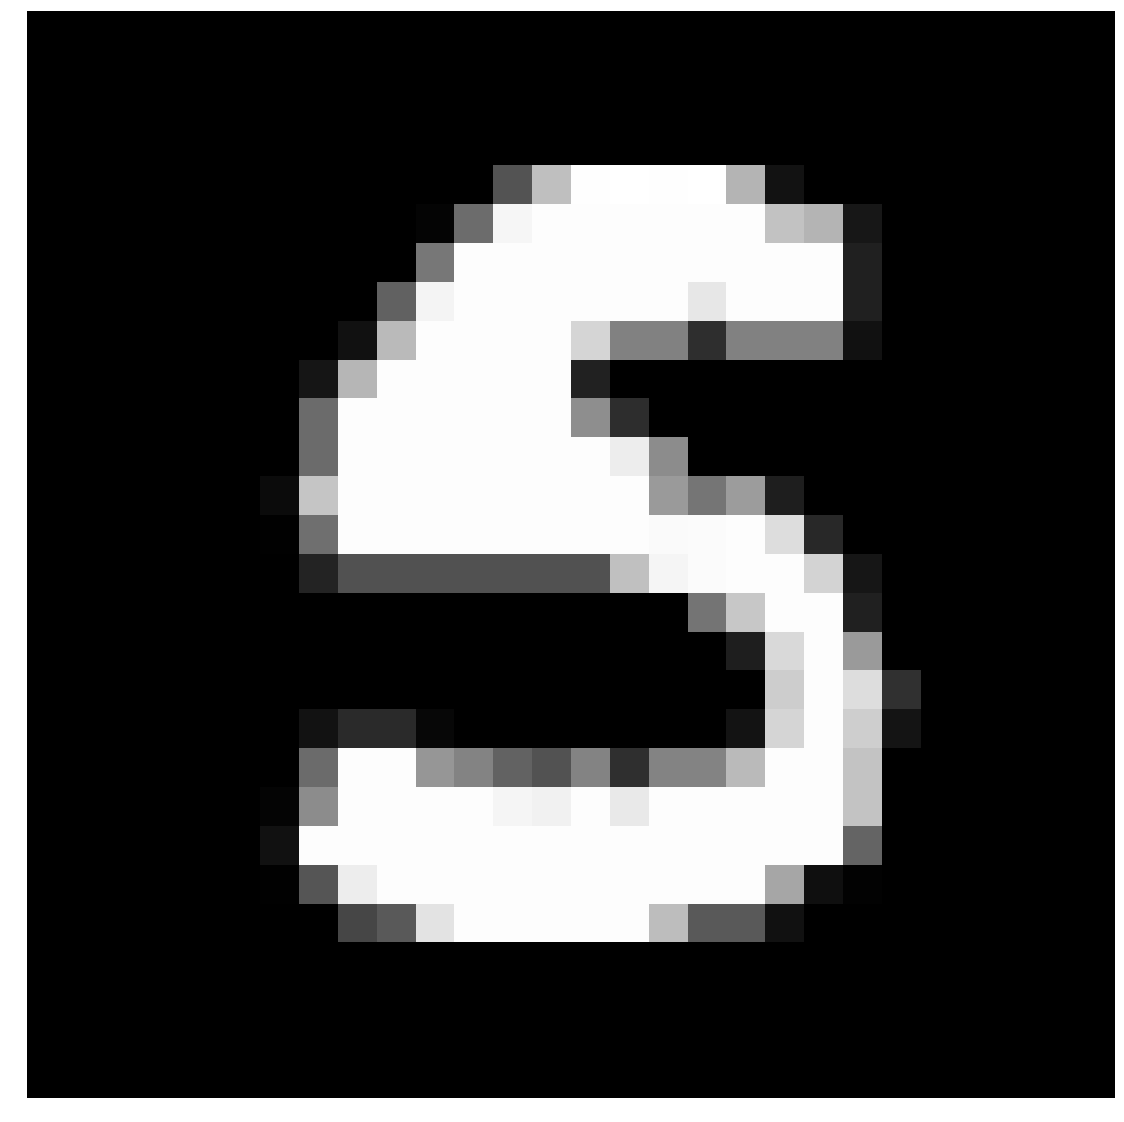

In [2]:
def disp(X):
    fig, ax=plt.subplots(1,1,figsize=(20,20))
    ax.imshow(X)
    ax.axis('off')
    plt.show()

(trainX, trainy), (testX, testy) = mnist.load_data()
zz=trainX[1997]
zz=zz.reshape(zz.shape[0], zz.shape[1], 1)
zz1=zz.copy()

zz=np.append(zz, zz1, axis=2)
zz=np.append(zz, zz1, axis=2)
zz=zz/255
disp(zz)
#print(zz.dtype, type(zz))

In [31]:
#Tworzę większą tablicę zer i "wkładam" w nią X - array
def my_pad(X, a, b, c, d):    
    Y=np.zeros((X.shape[0]+b+d, X.shape[1]+a+c, X.shape[2]), dtype='float64')
    Y[b:X.shape[0]+b,a:X.shape[1]+a,:]=X
    return Y

#Konwolucja w przód
def conv_forw(X, mat):
    Z=np.zeros((X.shape[0]-mat.shape[0]+1, X.shape[1]-mat.shape[1]+1, X.shape[2]), dtype='int64')
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*X
            ff=ff[i:X.shape[0]-mat.shape[0]+i+1,j:X.shape[1]-mat.shape[1]+j+1]
            Z=Z+ff
    return Z

#Konwolucja w tył
def conv_back(X, mat, Der):
    Z=np.ndarray((X.shape[0], X.shape[1], X.shape[2]), dtype='float64')
    matd=mat*0
    Z=Z*0
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*Der
            Z[i:Der.shape[0]+i,j:Der.shape[1]+j]=Z[i:Der.shape[0]+i,j:Der.shape[1]+j]+ff
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*X
            ff=ff[i:X.shape[0]-mat.shape[0]+i+1,j:X.shape[1]-mat.shape[1]+j+1]
            matd[i,j]=sum(sum(sum(np.multiply(ff, Der))))
    return (Z, matd)

#Relu za konwolucją
def relu(X):
    Y=X.copy()
    Y[Y<0]=0
    return Y

def relu_back(X, Der):
    Sd=Der.copy()
    Sd[X<0.0000001]=0
    return Sd

#Pooling (dodaje odpowiedni padding przed transformacją)
def pool_forw(X, mat):
    t1=(mat[0]-X.shape[0]%mat[0])%mat[0]
    t2=(mat[1]-X.shape[1]%mat[1])%mat[1]
    
    Y=my_pad(X, t2//2, t1//2, (t2//2+t2%2), t1//2+t1%2)
    silver_in_blood=np.asarray([[0]*(Y.shape[1]//mat[1])]*(Y.shape[0]//mat[0]))
    
    Exit=np.zeros(Y.shape, dtype='float64')
    Exit=Exit[:(Exit.shape[0]//mat[0]),:(Exit.shape[1]//mat[1])]
    
    Truth=np.zeros(Y.shape, dtype='int64')
    Truth2=np.zeros(Y.shape, dtype='int64')
    Pure=np.zeros(Y.shape, dtype='float64')
    
    Truth=Truth[:(Truth.shape[0]//mat[0]),:(Truth.shape[1]//mat[1])]
    Truth2=Truth2[:(Truth2.shape[0]//mat[0]),:(Truth2.shape[1]//mat[1])]
    
    for i in range(mat[0]):
        for j in range(mat[1]):
            Bleeding_One=Y[list(range(i, Y.shape[0], mat[0]))][:,list(range(j, Y.shape[1], mat[1]))]
            #Bleeding_One=Y[np.ix_(list(range(0, Y.shape[0], mat[0])),list(range(0, Y.shape[1], mat[1])))]
            
            Truth[Exit<Bleeding_One]=i
            Truth2[Exit<Bleeding_One]=j
            Exit[Exit<Bleeding_One]=Bleeding_One[Exit<Bleeding_One]
    
    for i in range(Truth.shape[0]):
        for j in range(Truth.shape[1]):
            for ij in range(Truth.shape[2]):
                Pure[i*mat[0]+Truth[i,j,ij],j*mat[1]+Truth2[i,j,ij],ij]=1
    return (Exit, Pure)

#Pooling w tył
def pool_back(X, mat, dim):
    Y=np.ndarray((X.shape[0]*mat[0], X.shape[1]*mat[1], X.shape[2]), dtype='float64')
    
    for i in range(mat[0]):
        for j in range(mat[1]):
            Y[np.ix_(np.asarray(list(range(i,Y.shape[0],mat[0]))),np.asarray(list(range(j,Y.shape[1],mat[1]))))]=X
    Y=Y*dim
    return Y


def sigmoid(x):
    try:
        s=1/(1+math.exp(-x))
        return s
    except:
        return 0
    
def sigmoid_forw(v):
    return np.asmatrix(np.apply_along_axis(sigmoid, 1, v).reshape(v.shape[0], 1))

def sigmoid_back(v):
    return np.asmatrix(np.apply_along_axis(lambda x: sigmoid(x)*(1-sigmoid(x)), 1, v).reshape(v.shape[0], 1))

def rell_forw(v):
    return np.asmatrix(np.apply_along_axis(lambda x: max(0.0, x), 1, v).reshape(v.shape[0], 1))

def rell_back(v):
    return np.asmatrix(np.apply_along_axis(lambda x: np.sign(max(0.0, x)), 1, v).reshape(v.shape[0], 1))

def cost(act, pred):
    summ=0
    der=pred*0
    
    for i in range(pred.shape[0]):        
        if ((pred[i,0]==0 and act[i,0]==0) or (pred[i,0]==1 and act[i,0]==1)):
            der[i,0]=0
        else:
            if (pred[i,0]<0.000001):
                pred[i,0]=0.000001
            elif(pred[i,0]>0.99999):
                pred[i,0]=0.99999
            der[i,0]=-act[i,0]/pred[i,0]+(1-act[i,0])/(1-pred[i,0])
        
        if (pred[i,0]<0.000001):
            pred[i,0]=0.000001
        elif(pred[i,0]>0.99999):
            pred[i,0]=0.99999
        
        summ=summ-act[i,0]*math.log(pred[i,0])-(1-act[i,0])*math.log(1-pred[i,0])
        
    return (der, summ)

#ccn - learning rate, loopz - number of iterations, streetcleaner - hardcoded number of weights in first Fully connected layer
ccn=0.01
loopz=60000
streetcleaner=1690

matt=[0]*10
matt2=[0]*10
for i in range(10):
    matt[i]=np.asarray([np.random.normal(0, 0.4) for j in range(9)]).reshape(3,3)
    matt2[i]=np.asarray([np.random.normal(0, 0.4) for j in range(9)]).reshape(3,3)

#img=cv2.imread("E:\W3\GGHard.jpg")
w1=np.asmatrix(np.asarray([np.random.normal(0, 0.1) for j in range(streetcleaner*20)]).reshape(20,streetcleaner))
#bw1=np.random.normal(0, 0.4)
#w2=np.asmatrix(np.asarray([np.random.uniform(-4*math.sqrt(1/5), 4*math.sqrt(1/5)) for j in range(10*20)]).reshape(10,20))
w2=np.asmatrix(np.asarray([np.random.normal(0, 0.1) for j in range(10*20)]).reshape(10,20))
#bw2=np.random.normal(0, 0.4)

m2=[0]*10
m3=[0]*10
m4=[0]*10
m5=[0]*10
m6=[0]*10
m7=[0]*10
m8=[0]*10
mtb2=[0]*10
mtb3=[0]*10
mtb4=[0]*10
mtb5=[0]*10
mtb6=[0]*10
mtb7=[0]*10
mtb8=[0]*10


sk=[0]*loopz
t1=time.time()
for jj in range(loopz):
    img=trainX[jj]
    img=img/255
    img=img.reshape(img.shape[0], img.shape[1], 1)
    
    #Forw - Konwolucja, Relu, Pooling
    
    for i in range(10):
        m2[i]=conv_forw(img, matt[i])
        m3[i]=relu(m2[i])
        m4[i], Face1=pool_forw(m3[i], (2,2))
        m8[i]=m4[i].reshape(m4[i].shape[0]*m4[i].shape[1]*m4[i].shape[2])
    

    #Forw - 2*FC na macierzach
    kk=np.asarray(m8)
    m9=np.asmatrix(kk.reshape(kk.shape[0]*kk.shape[1], 1))
    #print(len(m9))

    s1=w1*m9#+bw1
    #s2=sigmoid_forw(s1)
    s2=rell_forw(s1)
    s3=w2*s2#+bw2
    s4=sigmoid_forw(s3)
    
    
    #Koszt
    dp=np.asarray([0]*10).reshape(10, 1)
    dp[trainy[jj],0]=1
    der, suma=cost(dp, s4)
    sk[jj]=suma
    print(suma)
    
    #Back - 2.FC
    dk2=np.asmatrix(np.asarray(sigmoid_back(s3))*np.asarray(der))
    weight_delta2=dk2*s2.T
    #bw2_delta=sum(dk2)[0,0]
    dk1=w2.T*dk2

    #Back - 1.FC
    #dk1=np.asmatrix(np.asarray(sigmoid_back(s1))*np.asarray(dk1))
    dk1=np.asmatrix(np.asarray(rell_back(s1))*np.asarray(dk1))
    weight_delta1=dk1*m9.T
    #bw1_delta=sum(dk1)[0,0]
    dk0=w1.T*dk1
    

    #Back - 2*Konw, RElu, Pooling
    #dkl=np.asarray(dk0).reshape(10, m7[0].shape[0], m7[0].shape[1], m7[0].shape[2])
    dkl=np.asarray(dk0).reshape(10, m4[0].shape[0], m4[0].shape[1], m4[0].shape[2])
    
    
    for i in range(10):
        #mtb5[i]=pool_back(mtb6[i], (2,2), Face1)
        mtb5[i]=pool_back(dkl[i], (2,2), Face1)
        cz=m3[i].shape
        nw=mtb5[i].shape
        mtb5[i]=mtb5[i][(nw[0]-cz[0])//2:cz[0]+(nw[0]-cz[0])//2, (nw[1]-cz[1])//2:cz[1]+(nw[1]-cz[1])//2]
        mtb4[i]=relu_back(m3[i], mtb5[i])
        mtb3[i], Dr=conv_back(img, matt[i], mtb4[i])

    w1-=weight_delta1*ccn
    #bw1-=bw1_delta*ccn*0.1
    w2-=weight_delta2*ccn
    #bw2-=bw2_delta*ccn*0.05
    matt-=Dr*ccn
    #matt2-=Dr2*ccn
    

t2=time.time()
print(t2-t1)
print(s4)

6.616867540766797
7.116198095592576
7.164876310423628
6.5307075073709315
5.3477259667222246
6.079781681349234
6.015933915736482
4.609171847560617
5.451198578503164
4.913426220220666
3.226019537894163
4.721946825093707
2.757849718735332
4.318113244329434
4.483026516306038
3.753188071471388
4.315603930566937
3.63640142240719
3.2899162793210244
3.1797763112354405
4.0614815885373075
3.9759533930176407
2.959870898543439
3.726001297918749
3.0535148160344905
4.658048444350619
3.4520058916486143
3.5712896509721572
3.1317913486287763
3.965670823326596
2.6618122098197867
2.9998667770657237
4.247021163542712
2.957266074732431
4.8734515408606205
4.482963580622973
3.1844254758304493
2.65566408375524
4.6070389895645665
2.8535163634550633
3.3746265715475667
3.5389818757705345
3.7541591916704244
2.96004469780297
3.0275206030377975
2.4281270958732915
3.7886058817751502
4.1229663779706955
3.1648505908291575
3.232097555643142
2.704059151248026
2.9120251609584247
4.139551059700671
3.7375988372724174
2.456

1.85790326525243
1.1712975566366735
0.1522864052698763
2.7901275399881764
0.5300154263654331
1.3279057054469097
0.5443954162407371
1.9155339536649103
1.3387796710557023
2.585909542270897
3.194939424082267
2.8513102322577017
2.754223015578133
0.5772589816198435
1.9989697837624791
1.3871946374005084
3.4942207222360064
0.17349657798285856
1.2185549671363929
0.6220011268531791
3.2671084759577913
2.220402737550792
1.3680871116844586
0.7963979708066472
0.6090163564289232
1.1331320312423434
2.206040727681709
1.5224023727539466
8.298036792494083
1.7824577670966821
0.2758730975121666
3.211194394187262
0.12656062752268682
0.7845763010985193
4.824862245671925
0.3176401976708684
3.0512248189628677
4.071590129079351
1.2160935552760321
1.983958244079913
4.936760256267682
2.110725151264819
3.093681899219692
1.3273098848366316
3.0628830413462333
0.43180127706130556
2.222482612780518
1.1236500417435955
1.0154721908153497
6.2345056827638325
0.2988027207159521
2.426409349979142
1.3060556070931393
0.73016

3.988344021475806
0.5475869065070802
0.6452727592420275
2.1802154566007688
0.11637551157949927
0.6242252083270868
0.12999357550569535
1.011974519789361
0.060872973911555564
1.2803267094088289
1.6602880739880592
0.2127798167946037
2.3217964437512912
3.75673426064635
0.6432202806055548
0.48927533384308053
0.37026222242661905
0.5956765367272614
0.4888748400768654
2.7592328931713
0.287872706206179
1.596284580557952
0.5400198411554054
0.09639164255120705
0.5466306274972983
0.02021118042432579
2.9409256208424766
0.7180119294026789
0.674081922587329
1.053450169805008
3.3830643809011893
0.01880346979632828
1.8545156702218217
0.1834382724651999
1.383421855468142
3.1760484297209035
2.9887758840628424
0.5572306916536149
0.7713560084212266
0.025879983822816824
2.9926058504977755
0.1449009617966523
1.6473855965621569
5.358994646263543
2.9189452921752457
1.8345663427553434
0.17554954221829044
0.021176311429892597
0.49269797988215036
0.4392287169900903
1.4266024403861322
0.40186672582621846
0.5035459

0.5357866678744592
1.7437019642789884
0.21212860130588196
0.596142716066363
0.2527675261529233
2.4847897081461725
4.914527875604288
2.565388022913792
0.11205820505560862
4.360861512409786
0.2940587677458404
1.7969027103599473
0.04319047097170843
0.8384029117911174
0.37342992526490937
0.5823424080812724
0.22784193020395502
10.472301737353629
0.08860438524788507
0.48981180058659296
0.6989745445271752
2.7343735499070854
1.178585593431311
0.29300436164535304
0.4502173905132188
1.0321326467663527
5.1914750925231035
0.9838230095367622
0.988957226227773
2.162099928703711
0.7813674158382072
1.4683624482735946
0.040635085834786894
0.38521743449193263
0.11079627522422765
0.4027991276852073
0.09157153746386625
0.13335858377868934
0.48500675707736374
1.8650395983716666
1.6548532583047395
7.278811896491341
0.896270343765228
2.719552189149153
0.22703350464150307
2.055390286553897
0.15280747627144906
3.8147730737479346
0.9417700863478625
0.27030816887400133
2.1567034838235197
0.17618857125125448
0.72

0.3634385775226017
0.005875899335072531
0.19992550911516704
0.5931381486262326
0.18127212800263237
0.17108419888052268
0.11410515341919902
0.19900584652490916
0.034876198017616745
0.31216359836065644
0.04802509534181187
0.011241529698207438
1.4004146282601475
0.6436419657291251
1.218171975641179
0.007043699661032343
0.04429021397308158
0.006982816993413497
3.2918573607394173
0.011937001625713558
0.029649568638703543
0.012455511914944976
0.48953084483441905
0.010092570523526209
5.929254518211091
1.4630066828690271
1.2636037569613168
0.40154571298466074
0.28638767168407386
0.040404542481182845
1.0829962972794822
0.1950560685227986
1.0259725464120486
0.09863423079027883
0.23707512761117033
0.5385418620961803
0.3215686878993177
0.05671480054410804
0.8068698148723638
0.287054640850507
0.015352929311439013
0.00466928289373216
0.036178606877297556
0.05367457921889143
0.1805638796753629
0.5956124688205524
8.359821656897273
0.04759969529197297
0.1321698678738016
0.010833203450119344
0.760048613

0.12665385653650874
0.019663116580715883
0.011504348142351043
0.017524281677192943
6.623808065625727
0.15980235243655996
2.9576629156353222
0.020700004542083903
0.04934485809302302
0.13506908596063535
0.18882952698809183
1.821913369679329
0.6274542765394241
0.2611894077729239
2.7409312513059447
0.012512366796742393
0.013219735059116992
1.1825120442185513
0.30020679185304944
0.8996505323974259
2.4782083038442067
5.2132633843279494
0.6653901150765151
0.05124058193068299
0.6450206607712186
0.3029734800340948
0.28223672776743014
0.09892389493826105
2.199132855823372
0.06131701173333952
0.8451178455523602
0.47081195851928137
3.6811970074015807
0.8809173770330742
0.08465503333600163
0.03140825414192408
0.013071503172516513
0.010070064827103667
0.07715013661403158
0.012977780613585094
0.17795241821796262
0.01128469519555731
0.01943375777986777
0.41775798297684413
0.7617514783541249
0.0015108529616897474
1.6909792024960417
0.050257003561357205
2.784529432170618
0.07906351927281287
0.5246315526

0.10716805796119083
0.1084023488355782
0.021449161715261636
0.9935965915799437
0.002125148334441105
1.6870744406825648
0.4906866338693767
2.3948878157347275
0.0036316125912388164
11.070683044692247
0.0357968839740847
0.08403835849360447
0.13772327295775214
0.3923413146370166
6.595450149804334
0.28596303505020876
0.0010904929026654007
0.14363413877673842
0.04144006022403916
0.27969697147815054
1.763703237446909
0.7309685549295017
0.009803881912355995
3.947247088793357
0.20497256011470422
0.06918526206067667
2.099267458852077
0.456264541721865
0.18095609422356784
0.8108969230438371
0.2450746169220881
0.3227650835340121
0.04945273636576761
0.24423915331199994
0.07768283360211443
7.6014000261607215
0.0746092442761515
0.23101500962099125
0.018477383406542352
0.791602252791027
0.27062832407403387
1.1510348287857106
0.09303094764535529
0.12394878435993038
0.0064298037463191285
1.711425352167394
0.2473039434774289
1.9343465610388801
0.10577824788792514
0.08783997301111805
0.015244354666653904


0.289260277554078
0.017004892762743352
0.2856948455338859
1.2464574593033813
0.8692337483676994
0.10976006793599359
0.23904470887798807
0.36379342079449406
4.0928918463079675
0.05008872844049747
0.0258945665097202
0.09040477641063155
1.600887783985402
0.22852766962123422
4.123175376672488
2.5697072409232598
0.07996506236228174
0.579779936195867
1.4483857198831234
0.08840691373879903
0.47541941344622063
0.6677455706503378
5.852881480937726
1.6440286352494786
1.7124314856532947
0.6263373838013679
0.01095912837025586
0.07811833285023977
3.874708242094033
0.12934111749558028
0.7328907296053188
0.34718959678513045
1.038143004270005
0.014890258152608605
1.5823788878705862
0.1585379820617827
0.14595321221258875
0.1914858740992859
0.07882043967714715
0.019710577928906257
0.37046491290052014
0.05207801286992644
0.2685680348134585
0.11214904541828043
1.2328285857966295
0.034608010536192765
5.687265920691142
4.075285512628092
0.3726948778436182
0.4268945545913627
0.06635753249770322
0.08721636426

0.4600776183999269
0.735203544597192
0.184345464626476
0.10384686431375423
3.8679367879971154
0.0567626074076231
0.10176225677945873
0.10079132029646384
0.13143293486809543
0.44196783555080427
0.06036421800529623
0.08126406143414774
0.01891963976705177
0.044793879050512075
4.842021885531601
0.08838527403074688
0.029574396890352992
0.03835387860292617
0.08026581498111893
0.06312839838484655
0.9634801420899786
0.618119925445004
1.6656715849415036
0.02515280274740815
0.6717449064030014
0.0068877806569196355
1.9234993192546253
0.050195793822902235
3.7029690920765366
1.0595012440617828
6.2867332213384115
0.13546694492922318
2.596138305614855
0.11019941280112376
0.003188955974466926
0.5867197189340295
0.01803229617419189
0.05487695065956602
0.19768595671883415
0.27945500123065015
0.3880240667790769
0.1525412125927457
4.821128858571114
0.03045274952875113
1.5891876721200313
0.33664307433208807
2.723304453652728
0.12010010967698476
2.3945488603398157
0.007987810059926569
0.3833858553314983
0.1

0.015851298651810838
0.14812877133244068
0.016941701974598385
0.5771417544977635
0.019931574233907647
0.8812663218164811
0.6062443527295442
3.2993385373363773
0.026083621072438393
0.03725226453792811
0.06373787678504665
0.23164664521118103
0.05201132760596725
0.09723542523072974
0.09170646136276372
0.042073259637669176
0.02893919447265024
0.5043298710067199
0.007296755629460186
0.01067644865924052
0.666663803512275
0.07505493151202473
1.980657123917461
0.27637065322099663
1.5718220780443841
0.1264379873591722
0.01676082126022135
1.1105690730049373
0.003781191215490205
0.014901940162969834
0.8407080961457005
0.49209871494090585
0.032354247611587214
0.8750886433762999
0.03767668328241206
1.8414717314421734
0.05890652926591616
0.417896801301265
0.027469472466640964
0.016005969389052594
0.014892769033961648
1.6784653129052993
0.2157929049877728
0.11526193052435657
0.09729023959708447
0.15336516009471762
0.60812004973391
0.20717971854312137
0.3186190837829675
3.921912940421399
1.93453042038

0.27617709883922453
0.09997448092090727
0.015617980514208887
0.5986565506164453
0.011736465722209228
0.01216285554199063
0.2129430282596195
1.005342214830277
0.0011914525143662824
0.7334842204306321
0.4764903203079633
1.38595552313558
0.05362596751448358
0.035942354190017345
0.1193568173150054
0.06891203576050492
0.0946069584923512
0.1411936302553894
0.09099794322337681
0.011879665575071249
0.02800493263493903
7.5566724165680546
0.02148816612708227
6.7282951093547965
0.10186158632776321
0.07502905882163505
0.032857231840102134
0.3289089196067837
0.0004403889327755718
0.30450285632161056
0.09088730108927892
0.3463243827673854
0.018342872653931846
0.02780046994470637
3.3882980807989247
0.13806529660110248
0.2987262540183455
0.7087515513867736
0.32142588593451704
0.294244718691192
0.8121417180878554
0.05656750221203639
0.16070700726284814
4.846840560221334
0.25765412007015165
1.7089662455992787
0.029993261349446125
0.3923922965466937
0.027202255980831588
1.008949956593732
0.02771070823480

0.1834524543729584
0.2037829572175624
0.16533688577901456
0.015744754332238625
1.1902773900558692
0.4882690615917921
2.382002512687162
0.030103220039069494
0.1554761797038105
0.015816505983700845
0.08299155498590693
0.39870966512096895
0.2203050173491509
0.268949836843353
0.009172585574684788
0.08237275567790249
0.07849548721664242
0.48971493548631645
0.12984722769846319
0.2497810262520423
0.1851489779556543
4.1293139486716175
0.02794269683579987
1.1932843753087987
0.021453645273627142
0.18511157406417694
0.02937904276905829
0.042276865541947345
0.06827297185174701
1.6337974687089079
0.026044382647921308
0.24573398831803772
0.10906775942261321
0.031242036750117524
1.9423596052793415
0.01982977972509018
0.16571395188623725
6.652803871327526
0.9892498600081554
0.11807162992833273
1.0379358595273045
1.6327216653446108
0.2629476937957142
0.11299821669044445
0.0837231705000302
0.05619669026620478
0.010505216132337476
0.10766411848177183
0.29237965812291483
1.1186961059967468
0.0284432641134

0.09345611036487923
0.056211064873238306
0.18163145866779368
6.166096947017921
0.24354570357409444
0.6194979591093861
0.2690651791567466
0.07000021546115125
0.11778762031954675
0.21850254617715792
0.22787762555120453
0.9645509419260562
0.04973544554663762
0.0027270587144718377
0.0035556583869189567
0.07799173464804572
0.6097658827894693
0.09295295498189918
0.06465611111899229
2.2937438327715767
0.0207287025961563
0.9176766419947355
0.28328392841291283
0.027846353749405153
0.023776559385074458
0.12120231247203696
0.06538996010722513
3.01538536650173
1.4193979320735703
0.5196691602158638
0.02166774874082838
1.3643150759949685
0.15293770124638692
0.03055784375504462
0.02065488135033169
0.20887560404535851
0.02068480109955586
0.2546404785792441
0.7250349787648858
0.026366677998591076
0.26010815258898623
0.2404695407674157
0.023673633929507696
0.6523860609665735
0.35730323383493806
0.25305925908688415
0.5105841743608557
0.00874768810172467
0.04572391667425775
1.6008475913953775
0.1661551232

0.43668506379357647
0.059906382745075745
0.2411965768396442
0.04382790253133072
0.17637056691619574
0.05784382732104814
0.004639117731392412
0.0252739042447084
1.035096188076082
0.24223175263281557
2.932781769377642
0.009728349763643436
2.9166618003662026
0.03561103167914131
2.5014011735209225
0.16919311552474403
2.497106260496936
0.5800403451761926
0.044815987204908626
0.0711239924288964
0.2528675824694663
0.009739263672521042
3.5657057963034977
0.024405781598246263
0.26901211369942646
0.033884769055512874
3.149570389603514
0.09241857041043244
0.08526777320860124
0.9330019131790428
0.0215366228225555
0.06554656355485058
0.12768780504129848
0.03578649006734039
2.9959599419571243
0.03732235330331182
0.03222963733099599
0.06913726149622988
0.04658214187258189
0.19425243200323283
0.11520611943087945
0.05695975963369112
0.1370979401680985
1.8204366916836046
0.08916268679956753
2.1232460276121463
0.12146308005673266
0.042342617170434735
1.6539374975548
0.021567650648345038
1.359452710795581

0.04728639224377186
0.06166068340827683
6.774380575517018
0.0502108391148467
0.1673743549770357
0.24512214718335282
0.06188313379531362
0.0023664967138662405
0.022866204120175194
0.2093926573944896
0.049178981523868924
0.00376929747658199
0.010677313944598525
0.0004950493670458394
0.016886318321507384
0.004254737403109498
2.2721284738778023
0.026875463741462047
0.08017128035632676
0.4343998140471452
0.009157256468945996
0.0063527977678074325
0.010791249774921845
0.06327961501865217
7.474529964144665
0.11813666985702831
3.2022425639335257
0.14833962142411258
0.0105645628838263
0.027396288494051145
0.5277075186733656
0.5115181433655032
0.557812927291643
0.14027161156615386
0.31766629934947455
0.05919778244221259
0.13548919414341054
0.0025642931144418766
2.3521885854291003
0.004074468697561379
0.16553797119149416
0.038630756408540294
0.15186070869000945
0.8368296961799727
2.8056847019607978
0.00971579273562451
0.5114265581320184
1.1634536758900946
0.006928131588457463
0.07941822656442722


0.05228055721970486
0.3813724565072058
0.0039059436588204507
11.643986715278764
0.05625411296882069
0.420203374369161
0.013792507872359885
2.9947112989143783
0.19752455487885953
1.15665302953965
0.06587044547222104
7.573005294397467
0.020277248151567385
0.020440110759150303
0.027198468686570394
2.9736440697738886
0.2056403049572413
0.046259120386094595
0.16218640840666326
0.0012767194275131886
0.5265819933253538
0.021128877332882323
0.01185947738306269
0.2255671725445333
0.030529626316356192
0.015476974126619148
0.01582487524460518
0.0630384943683434
0.0987811239330412
0.7400561682279018
0.862811805561902
0.0571638514498927
0.7804329165095226
0.026466842301135624
0.05053492559990509
2.1156777309139443
0.01488310333490438
0.4776477978698441
0.14110913445129536
0.034141779914714204
0.08591433877820731
3.744443965258736
0.0004716712765485837
0.7716880700238785
0.018214900568191517
0.04037312360180063
0.016090043478068142
0.019968083173388423
0.0719753091837594
0.8723193092516234
0.0391644

0.19168992035159702
0.3546278413032999
0.4046711217718174
0.9353016178183908
0.6795492856990583
0.6556053002655444
0.08318952444257036
1.2805233074085012
0.18780944539927127
4.490410573065492
0.10597195427349423
0.0907714257448736
0.0944173309594962
0.06003656603668889
1.8937147311567788
0.8835430374972801
1.50998830598195
0.24960034679969298
0.1158887445315223
0.037215713830524154
0.07849580463124589
0.18023139125236087
0.049418517638634994
0.025797817157230826
0.2649861731703733
2.5174441677756074
0.02949131192113428
0.4847134462699263
0.1419840135173676
4.2434312401130265
0.04435840116005543
2.4358642599134748
0.07147104326622387
0.5754749780767723
0.01775017577636323
1.0607884163255565
0.08777838749878933
0.14462686596491425
1.7842320681356807
0.030070338842596148
1.4833813409372347
0.3466855922155864
0.2181802516026758
0.04686822856197997
0.16610086832981816
0.9204819971991468
0.04800783272769939
0.009778089048242126
0.07865672417484607
0.5557143415894035
0.0054511696165309
1.5651

2.076327385276986
0.25843937997128014
0.09088665854753804
0.014235622474665841
0.2072766120596739
0.010905917775673136
0.20817374789177134
2.606264547905237
0.5214974006173556
1.1009335640550173
0.052150347490737235
0.02857838296929021
0.0021144075598658395
1.3337991936571232
0.17208972578081957
1.6110279138703008
0.013973143836770617
0.8343256736573292
0.021993381478977572
0.3378427738546999
0.14629676613956194
0.043082792436730466
0.0667381011356408
0.5837261921007111
2.0722223457948195
1.3541219290812112
0.1695348777004979
2.791428830916819
5.627076123953498
0.44794567818007186
0.1900932262360512
0.003789412131772592
0.9439225008466536
0.007741303254272022
2.06753932794122
0.17700531523718227
0.0349802678442641
0.1651982668689169
0.0026821073876923673
0.05368921500226185
0.007218869246647336
0.2324376721038838
0.018397540768483947
1.75381056520381
0.018309054195660496
0.7897629730148922
1.315705562697867
0.30902881749366007
0.07837366994348137
0.009552740418331703
0.2420748279130627

0.0319274195841614
0.06833893260284751
0.06197638546761212
0.04001618818477989
0.7184012058404516
3.5275869366544956
1.6824079308865216
0.8582714973036931
1.6591191767051199
0.000663974026165661
3.3461660546524783
0.911828384564577
0.6269667954069794
0.10023846597908427
0.03100260928900055
2.4051851186131135
0.40554268937499793
0.0586796778676712
0.15796559271959904
0.07836304689757363
0.1503687403410951
0.006623878962452693
0.34607140276682463
0.020593763362417868
0.37096632410405844
0.003583127568104137
0.02481944899531295
2.97481612692958
0.048127323619421944
0.20081302552881558
0.1674860567349159
0.16553339086571628
0.4695661687082629
0.130307162030737
0.2448736666951541
0.0009418820313062739
2.9020020296897693
0.10731175908041223
0.7659012546645673
0.18849829049725067
0.5941601427807885
1.2751494097377876
0.10780960410201892
0.14551373393301195
0.0851821980384186
0.1775702585596739
0.10717182861809015
0.049845146057914624
0.03903450979343965
0.04531895350746635
0.2126661957475312


0.021657662059519526
0.05647463530402612
0.03351427694282669
0.12169853632598207
0.2769643270944261
0.0952051784852894
0.03236745568631303
0.047612639670995716
0.12408614880724296
0.011776258482530047
2.7497859411157366
0.02719449225798924
0.13845826825902444
0.05245640876045048
0.11603268415986101
0.11672126320410962
0.8455155719143516
1.1505136373481903
0.1377701750858445
1.1985877889230578
5.733126996263858
0.014327270465167047
7.947160784763461
0.060494775719845524
1.2879800151696212
0.2827255945087736
0.06592686727266343
0.06119370600482834
0.37801495671638274
0.07530025243492469
0.5840604052686588
0.015528737461084805
0.08603404536690905
0.2585918536688099
0.7804730627926558
0.1453958224145166
2.4296204420158563
0.15257912933601986
2.6671944278125492
0.45197884222767887
0.5115893830336186
0.26640342870671796
0.0064468233235374225
2.8158574624008894
0.14754886333465414
0.031163427204764785
6.675124373686535
0.46985673266449557
5.14543693327169
0.03427889147197411
0.198824389061043

0.7618300168661694
0.0018080569000748204
0.10904723387102236
0.21926596642365637
0.08914779923119416
0.007171385869785885
0.01790222981122087
0.0020055093475197052
0.007125536396501878
0.03693545926102884
0.07242856962271789
0.12476470301822906
0.009209948475841934
2.315791676543613
0.024234984236797506
1.1265492871173388
0.41374872369375976
0.026761272567433166
0.2714598349101511
0.04879646817548826
3.5396809897060453
0.07833931591107783
1.04487031206677
0.01335487172853706
0.32926724071961255
0.45000768778682587
0.1301800269685368
0.023932197955138873
0.10133787598486313
0.018352521801708363
0.32005366463688545
0.7037878883772635
0.18493665190459863
0.7979449578299179
1.518689195395443
2.885899852794542
1.7634936306748068
1.466394830965103
0.04414188737934367
0.1376317071586715
0.0887705143490535
4.4099051009000725
0.5517187509401725
3.1171077974522863
0.0683713793042835
0.09413345140452416
0.08340826118963326
0.012999297252831209
0.05338793256530271
0.02676890448438875
0.89110019566

0.01150046976773633
0.021995342131535135
1.4596499773258127
0.03874344007859549
0.01811471380180502
0.039120712089956336
0.9804607529061522
0.14552656186562268
0.0483869293077459
0.08655705664395573
0.2519892525409119
0.025158947742118482
0.05330425311008326
0.03945118078613259
0.037182754565447756
0.060150591094221495
0.31764856816261133
0.5614393330400074
0.32921924756269116
0.0032907734054178172
0.020277347543839582
0.16244180676750328
0.3177394379183839
0.03206875441797394
0.10727326768661374
0.03758300694167978
0.08293663498316045
0.06800551871347862
0.07429970837892708
0.009144765369768262
0.07503866008904814
0.013549473625328459
0.4256583278551672
0.13178636593907983
0.4522844591547434
0.048402567458154536
0.08920370477687614
0.018917738881093472
0.038207665017876286
0.32600156251923657
0.291891851220592
0.3924952186987216
0.08141376203889619
0.10296141814963802
4.965536659312902
0.9773664472161475
0.23578447540340294
2.4513240130856326
0.108018964468844
0.009806123234794394
0.7

4.041705854409706
2.1042072346817746
0.02179606601994191
0.10105789485298314
0.12170857997664218
0.18849118630007589
2.8960057448572627
0.03822216606727095
0.046924947712786276
0.001890318201056399
0.0007133571551617969
0.06903044410586524
0.010740429791085856
0.15500586036866337
0.09767027959996491
1.3355062375515558
0.015935896958583877
0.09664145403100922
0.02817322107361239
1.1623663351095006
0.3150963109926347
0.09324904237136893
0.06347176449728961
7.044647344181413
0.013837509718473957
0.0603633422994075
0.11596530410361311
0.04612584069077158
0.07584464645844322
0.06088045401930952
0.07370602949359281
0.017244674965071326
0.41605764142190726
0.19230288439995868
0.28531893365479655
0.11614706585778202
0.015739547711515187
0.06807080173930634
0.3216487540391769
0.034958139915067105
0.1642984787667659
5.841513966765712
1.4851833505115863
0.04527977085362608
0.9333865291693828
0.1298979734799953
0.011532701160851361
0.6137523593087081
0.7005599826022795
0.09318676700611264
0.523746

0.5254508651486999
0.005203073176088373
0.2676007524950072
2.061384437251499
0.047848972309283186
0.0066594944001769985
3.224468903939249
0.0313471086931288
0.3648851986293029
0.12796713725847575
0.012890502030386025
0.018473624184026954
3.9012719065580956
0.00489737186661811
4.897431691099774
0.0467245276196369
0.22598438112167923
0.0190638363783327
0.025105723754943493
0.009866435760590635
0.01197465266695112
0.028242054621790517
0.01778146067849639
0.026288547301391157
0.04307298575593622
0.0629671369037094
0.00620741078717235
0.003069163271935291
0.04128035524230267
0.07425260353926201
0.05257415402997673
0.020660374580253865
0.04226743830665631
0.0072729689284432375
0.8749071410332372
0.016106405967435605
0.23022475187171398
0.049986769547506055
0.016486597612768265
0.025686846512571523
1.6660008087280636
0.005923698351921006
0.021700382803013497
0.04014002838283475
0.0165133684504888
0.004888185171004061
0.01864989476422027
0.008837717763958069
0.5201086370653502
0.07480143047160

1.486478245846624
0.3821336291572438
0.15649919858313327
0.532549052057823
0.26808596147692737
0.1434831790810438
0.38277548671258255
1.3110426018832946
0.0018879318836645164
0.004164132384564415
5.822866053989866
0.13023467577642658
0.02840500478373302
0.001387324005024146
0.07119526921174313
0.019998549871665487
0.37759557561537765
0.33239242289624854
0.06049215439786568
0.11997685393424616
0.20323319288431368
0.03835344108984212
0.35848725079250426
0.34304735418936355
0.3349763830921767
0.06068364977103992
0.03802567615790796
0.3302981673412256
0.1919502068966378
0.014555396897824638
0.021018417955379537
2.476100296565791
0.2143921652099169
2.13271614353398
1.1972029230413
0.293786611610073
0.013171783125788924
0.0023929693383553316
1.706890133059501
0.016306217836975768
2.306456168307799
0.053667903961365344
0.0009390263081408705
0.047630161720277134
0.010063635119292686
0.00136206431276425
0.0001563277297748312
0.06849881506954202
1.5982853470473275
0.0033069073953935642
0.7468626

0.055250873387214475
0.05751329179084844
0.014477837328065384
0.10592356096775067
0.00823047354908841
0.738331981024973
0.1340037212793131
0.17941458992760861
0.04915256747644046
0.0005213153305505032
0.28392754195562747
0.0368668759433274
0.018685497534114075
0.014298908719939446
0.018766852243398684
0.017745086295813995
8.014360867901068
0.03100919008936029
2.211177381783308
0.01599647837925001
0.13800748584132805
0.14424597668940545
0.7937569032365387
0.0027057078061664634
0.18120315217998587
0.0004954873369045034
4.044698990371085
0.03558654205908931
0.0006944823511805164
0.0007118682088192187
0.2790718965394287
0.0012312841373691458
0.05322765265466416
0.20324949853329366
0.0032625349328266437
0.022994760178065957
13.04460151050816
0.2548370476863894
1.3932005492994413
0.009946277056169028
0.003903469158749649
0.017573357138911175
0.57611041377652
0.026217718913411656
3.8052463201367273
0.09198242262896447
4.3358065075285745
0.0014859234629049703
0.026450572260467143
0.08028278050

0.9105100072506909
0.017328756765662607
0.03369473155514397
0.05859461008989224
0.19082295960402923
0.06026703189567621
0.02502081751905803
0.020602213379776045
0.11666150113657581
0.06607801511381048
0.5479562130540502
0.06650880392000619
0.1495921532889551
0.08196826806282614
0.9427880418933661
0.0820506755202418
3.439139741508776
0.053242667542212366
0.08967136283106199
0.007836781245592237
0.08483015368800012
0.008696020601184887
0.0165522329422128
0.010105490789810151
0.0288452388691886
0.018633013945934345
0.03639641188538865
0.012399645099678313
0.38340311882468187
0.31015520241030003
0.09507531798420633
0.011325696965621202
0.022933668294143433
0.011001844751608399
0.012794931038461426
0.0031681198643144187
1.4544625363468353
0.3736233167845421
0.012071964764679262
0.04952156389434336
0.9653565215255147
0.3458643021099936
0.013326778914722323
0.00046631663102060213
4.090205976435599
0.0025091322951617157
0.01957853336747753
0.03283298680938815
0.0036610637081095324
0.0125310586

0.018721979603458557
3.686046681520945
0.09836798669549884
0.6137290824593211
0.44581665540018184
0.004205168005953449
0.02084357024668895
0.10542381354756072
0.03673329539252876
0.038444405000481977
2.350856350193167
0.37463761791156736
0.00884994583896145
0.010971287697468003
0.5120572567923944
0.1940158712225694
0.05031443145549151
0.7744102235686462
0.010071730307529801
0.7249094672644094
0.09263516485390937
0.02941849859603672
0.04722838043463255
0.17314764777483285
0.01296373195134003
0.5641517730346469
0.05281449715389308
0.01385026706460902
0.004952002387071626
0.017223967036789807
0.486728393034895
0.001830103968276228
0.0629629796454867
1.2382425325348827
5.109864811434974
12.871394131064001
0.029943452486703492
1.1823885443875106
0.01995683416160453
0.07390854201026734
0.1250291461799883
5.0161426157945534
0.0940434647415396
6.005254150899604
0.07696916264644078
0.0705833526867363
0.19475874304222834
0.07780743141183569
0.9823025749034775
0.11125609686385238
0.77929436278053

0.004736032853042868
0.026781140956070423
0.035019393564654444
0.37287950696416994
0.011960839069399697
0.5219492284612101
0.5569645240266169
0.009779945361478344
0.033057613248883844
1.9627134019918688
0.005278090414104075
0.0016307198897133474
0.03380519468759606
0.2813838413771933
0.5894709345314186
0.10113809719262914
0.011713673254793697
0.231145565725407
0.002780047764885895
0.012309142826555772
0.7754550831775935
0.011025195465267949
0.003379717545660417
0.07014992903605728
0.40947120728446934
0.005471953336054636
0.0010115909237190547
0.12275007402936819
0.021314678127577844
3.866648884595142
0.014100811770375823
0.12291176059143209
0.03331119639727281
0.015892830973841456
0.04694245108301494
1.5432357401423074
0.44648780703339475
3.027736290770543
0.0008853711819665816
1.1468951584309637
0.08862535677773248
0.009764392490701651
0.09931932911192447
0.07268516344024263
0.6724864887503494
0.21512767654304454
0.008124871060770643
0.12341769214726478
0.01971873892538789
0.031943622

0.2652279360982683
1.6100735081924564
0.07427413281460218
0.12081143828870475
0.3175113796336853
6.241696828987081
0.32819787871303263
0.13262998450291177
0.6946707571882557
0.08889353329921496
3.624221963631562
0.3596989418423669
0.10837154423181836
0.08825489463781835
0.9110638818532574
0.030134000172563367
0.35591362134313315
0.0526877479610586
0.27463501478313745
0.005123389162314334
0.051170413384844064
0.027265600834306136
0.27644598324902114
0.14056715317542037
0.04829665672812045
2.381570377145713
0.17275425059370175
0.14710117862374575
0.23139549552385594
3.148591490079957
0.19850084200522083
0.016777178148363974
2.48884749178279
0.08337386180472547
0.04873448747328287
0.0022036524550634123
0.03578552591139018
0.3847817729094151
0.017764655234931977
0.13399970377098208
0.008937449163963627
0.14753200975258599
0.16787941944049986
0.005009000323650002
0.09764256080782617
0.2434360664660304
0.5171954686692706
0.009760016984860377
0.025957950632335046
1.9800912414957201
0.03655991

0.02240951640554337
0.3106666028815851
0.05636471133309696
0.028448299357958454
1.691688084104509
0.044194634642223875
0.5053657899488815
0.033324225788529185
5.601799324976507
0.7197106464186405
0.15489485243721612
0.15250449610947073
0.010112329123975881
0.5769939794973071
0.06393679689294794
0.04767675190739532
0.7928899442521757
0.10080525951994228
0.003057267269053191
0.10494593870614446
0.1522772630165792
0.19567952088736484
0.07218517920781793
0.012141818892067054
0.1463350827052578
0.004893672134813475
1.9980346287113064
1.118030083377126
0.7639428260588087
0.36442523308245134
3.2513073973433273
0.03351093458975014
2.6244234912123034
0.0463199303132846
0.018983141738073146
0.014771564343945153
4.506639403044929
0.03594256621913139
0.053663811626973756
3.2899734265929856
0.022625186488671054
0.10645283832170581
0.061869414635888964
0.2111316675464477
1.4864254831559705
0.035888828122155804
0.03936683862600018
0.07962900684325493
0.10187929178754199
0.052682787713698054
0.0151691

0.0021424517690206714
0.07114390712182095
0.01145108555889659
0.06624546166351665
0.004921805935355037
0.01746889838490307
0.0419223904339319
0.005552543807279959
0.7414112475191432
0.10191300958653796
0.010105309548722378
0.07484112131451706
0.005491843351841875
0.10304866995109373
0.009757890969432671
0.07473928490759126
0.41304658280021894
0.21849410259220045
0.020072179325740215
0.01768451923931119
0.02034350010811317
0.0739977063758833
0.12114680494279917
0.20934332114287862
0.06283069490358975
0.20078915184347204
0.3140083777370895
6.257519782858222
0.12843531146370277
0.011391070243782659
1.0579349214954124
0.046350504620644245
1.7352491632343494
7.841611651752363
0.09627424934338526
0.1216863689503892
0.47801530965759487
0.8324912703100228
0.005465191915976617
0.10263910214633638
0.044989629423714164
0.032178220193892514
0.07986328658430242
0.12243676851760507
0.18139142482482445
0.3010331931136445
0.03132481337904546
0.08878247917746328
0.2227173560445787
0.04150983697848324
0

4.188670694551563
7.373004407984601
1.0644948522190316
0.010427745778224492
1.6429288956543153
0.014067780307758083
0.10504832762779986
0.004399967947917598
0.17821273227854567
0.015362950726710138
0.03382370184583738
0.14977956272068066
2.0819120997553364
0.13438997466337238
0.0887694030714736
1.287252683338145
0.5140600781965502
0.013325240290179825
0.03214669731486004
0.00788737236690493
0.07761914831221182
0.019312049863666064
0.11375516473281386
6.30959226258118
0.483286245824452
0.13886682110898713
0.8503746593783286
0.3797395086067298
0.22143687811599055
0.007863877493087722
0.38004766841343385
0.01184724575584695
0.1384289969360203
0.03267422942773036
0.09205553202100539
0.044169993115990715
0.03647813089049287
1.2422989520405354
0.21192967832663342
2.1563879815021187
0.7373068446286456
0.04955028182205159
0.018169186854862733
0.010901585620125815
0.30571312552288715
0.02164725524143944
0.2205390844967743
0.0518931908963954
0.10640803749035772
5.220448257288723
0.06792305652557

0.03397105277632128
0.9870647265438274
0.118267898412675
2.0207805721865912
0.037424032159361804
0.027317975637176282
0.04376253873322649
4.14795799442365
0.5015947086203112
0.10109812441358153
0.17984299612255886
7.108855817787304
0.03755577791431534
0.18446111896650658
0.03159919255542603
0.22099740939792556
0.05959852375835609
0.3724284341483146
0.041840225151435914
0.06965691699402904
0.9356303531476464
0.014533469588647714
0.006832857793545518
1.551373000135449
0.0027866296301024994
0.0033620919359611643
0.5119988826494727
0.032765452477013755
0.12982503806100218
1.5685686351814092
0.00811143782564451
0.03055102203093329
0.04641685856373236
2.264387361716845
0.2747620854879155
0.04818021222489981
0.016730007785665017
0.10848021680748857
0.02142322071748544
0.002191002492872222
0.7386376387572062
2.053800119409318
1.96285804436513
0.003030098246856027
0.039627874120413846
0.04334019661759935
0.4123222711618703
0.4049721278158419
0.03482264395927102
0.19880038317249416
0.08463417310

0.018948711096752818
0.13743967863175494
0.007600099085813294
0.02255386415972893
0.10076621483850134
0.07056559167089833
0.6171000186958513
0.05665508781913225
0.037603392984214126
0.0876634323611453
0.015169440302684026
0.35326659476106986
0.03882797601805517
0.695956674265694
0.021569098889413146
1.5128146929096569
0.006104379030006256
2.3380658222485247
0.0032731992399965878
1.1086823124401761
0.04329444028952192
0.3483879978866874
0.00479823123043991
0.8389855621089038
0.004378555448645036
3.7030142951428124
0.08494965180435525
0.06858587891184494
0.02026178183986335
0.010188719698117075
0.011656367449222091
1.3814752894892668
1.2904238763975948
3.307847268203795
0.22913017826901136
0.14882289042503818
0.054148231067278986
0.002583297388802087
0.44866551673124133
1.2326814301190456
0.01808108895136428
0.5433132537752453
0.08843681704844686
0.23409507065493093
0.06212685154837048
2.381807520687508
0.37213274153827003
0.15047917690017126
0.25907686805041036
0.03600455979285667
0.091

0.09240774390094855
0.5301482662483571
0.1295772666001385
0.04887511650918034
0.056468088070573755
0.0107708303592244
0.3565971063999223
0.42178520297294814
0.060603395396671735
0.15364024843509402
0.36182446749536445
0.027612387699227067
0.0430895334690126
0.3129292029266921
0.35593526987585933
0.009806956083359172
0.0020240669195863135
0.04049552216963976
0.3348569286614596
0.18296903097488526
0.01683494591048209
0.16404832478730874
0.0225628312802454
0.012127642425138734
0.04365582942633317
0.0020267511106925097
0.0987691397546367
0.11000577444971302
1.3102517835005365
0.10640939393855901
0.03393279691762374
0.022016961490549457
0.29293069967962754
0.7106680724006482
0.9092547320739907
0.006676640498594647
0.07909535776584901
0.0013168431466204222
0.030697123899406122
0.14904713052384536
0.18770520805450377
0.007495942441482792
0.3769777133800581
0.002341587766170335
0.010041477405643113
0.011612123186073764
3.6771459996052682
0.05546601858230701
0.5240105305772844
0.001739888634887

0.030624152733348647
0.009517525482111835
0.02147013560721711
0.0021080979936845224
0.0037530414503303506
0.002052860667096624
0.03169085960841912
0.14179882975173114
0.0022612316885846444
6.155343909754419
0.009976371057658095
2.95609774154389
0.1538394188665106
1.1536039583377118
0.06281998998186283
0.061456322637600605
0.006362851759575975
0.22598868658004312
0.05444308722898267
5.885749841860307
0.00547870389962632
0.11460612218721279
0.17816487947813178
1.9633514838638766
0.19650537754433176
0.8696106802290358
0.15798193138746622
0.016671501396157994
0.3517930180048633
0.821277017506889
0.06254242333478319
0.07023431838075964
0.08524124254668863
0.4617094102796605
0.005144613674474637
0.34039248797687355
0.025397816524847065
0.030003230706865162
0.48946352802689913
0.01970429070084379
0.05854946312661772
0.013697514678627369
0.03157666424395456
5.6126185528066825
0.05603607823203111
0.05015563259785815
0.01565191050007247
0.09577954555883852
0.007686978915382003
0.0135327819343242

0.03479893087830863
0.14878517992660772
0.017017989621364558
0.24507721452281106
3.010613296868887
0.5789018379967634
0.05643145143570462
5.39381413111313
0.0073117564949282095
4.327356542199478
0.19760800815412266
0.016492484139602498
0.4279780714117228
0.43442283331561704
0.012209172514149803
0.003086395380794591
4.427528281155178
2.350830698485521
0.35921749022969535
3.5711498755787536
0.07504213027129872
2.1624559681971833
0.031030501749062467
0.008862651825076838
0.04926681056176978
0.11806330597058079
0.29364405652163866
0.020050151600958292
0.11055479496647627
0.23970681899548074
1.733219367872715
0.37541923603309046
0.0001482361425277403
0.19311662273780128
0.0029886556695364304
0.03854935542775266
0.9738493705793954
0.021770470162875488
0.003143898974135068
0.4056087041858646
0.009796304744944377
2.5942877928302663
0.004399018274051444
0.03346818868868072
0.004335874579224967
1.4957525471137918
0.0006525618513689639
0.03110802023593876
0.2939715411539091
0.0693934747547574
0.9

0.052502737019024595
2.9668757268996204
0.0972810048864704
0.02814260851483462
3.2580595477967242
0.07345800756471016
0.038480192603276765
7.0846606175634275
0.07354301098180548
2.6052640839281724
0.014531070217658473
0.896543703885649
0.1951835654245843
3.312421471483893
0.026357580994148967
0.10910540400424007
0.2708861019840604
0.15170425783039576
0.009092129768277014
1.242162601846684
2.802178221581557
0.7307193667735948
0.02876474819754473
1.7526539714659821
0.03284721271792686
0.0035580520011841512
0.11731262542308092
0.15146706293832923
0.13013543053172277
0.19111449691963073
2.7752891286403085
0.06686273870598373
0.045002945401989805
0.8575319833126787
0.3316289837409646
0.08649212368028268
0.15006358231390637
0.03548977850986641
0.0025116632874069215
0.01706803270001596
0.04748811197163104
0.8777203141876175
0.1425696557138458
0.19021938808788974
0.016387654844554154
0.024646060133648274
0.00034364109161495195
0.024248720685849042
0.0022806790869505517
0.07731056526508323
0.03

0.059946321836369554
2.103642565711285
0.48028836115288087
0.010937654172718452
0.01869558645285789
0.039432013239823135
0.03469630079543224
0.0020887202734717596
0.002283517634915521
0.0022735780014464494
0.018501190183462933
0.14711044713436697
0.13512941986844512
0.2828670534110589
0.0015864086879760738
0.0010364951658245235
13.22667352856942
0.6157986328405383
0.6051479766452673
0.587481646567297
0.29542231971628785
0.04129708789411166
0.0213337587176292
0.0025074229558878524
0.1784371613144718
0.01650809797422203
0.39497882433449155
0.6851587887355765
0.09414047079285015
0.020020166372614428
0.1152999001795425
0.013570389843624247
0.02791771628311229
3.0996098436540827
2.350039972706364
0.2065443077425362
0.05908875843455538
0.18870206607798512
0.8546110896089146
0.158167929596211
0.027669836619416993
0.7243737769157783
0.10239747285064094
0.036133149256126804
0.014319371461714856
0.013651416440106966
0.13695586323078163
3.396378673413832
0.16203903766968641
0.11992588255555198
0.

0.022627888261830393
0.08499522092796445
0.007141630716051194
0.020774079420322493
6.616310200076347
0.251031829363086
0.06051591838852891
0.06645652875013125
0.4874885196509211
2.638934465297813
0.06032523800864476
0.009766497484127565
0.012522667569909258
0.010912937144506916
0.013992991106607474
0.026409286993361987
0.01737465080952879
0.6705516412297577
1.3968771842945613
0.04787977193401986
1.6398448662916885
0.1599217236493053
0.08088536080764412
0.032130152066380105
0.7166492148309019
1.5846619290357782
0.022131979958819874
0.2367530541841926
0.020947350237437264
0.024691759737816864
0.3002140528716463
0.015115572789400065
0.10987999965891375
0.0325966887750961
0.009699172093978647
0.000413282228874586
0.7875771601199925
0.0417136349523893
0.07271435415808147
0.005112829858154622
0.012047783056713402
0.27926273995818135
0.016185723820763144
0.01264817958773822
1.6907114244194237
0.005236383681556704
0.28611587966469354
6.4706988972688055
0.0018690702873893155
0.3324341649604901


0.003907421791642373
0.0013565000843615543
0.9656533055232269
0.36655977159004194
0.016356368176714844
0.716278100418438
0.9693826152399184
0.002383409564034455
0.0992181692487231
0.022622454097097136
0.00738187176083905
2.2756198254356352
0.002790852856496497
0.004241512563209665
0.03546081597520101
0.0002996111231126793
0.004187055109523932
8.633490468303176
7.744717500360486e-05
0.07608883037728463
0.0017813486060101187
0.08635029196250475
0.00202198314948036
0.004603187153966566
0.0005430397131545173
0.7132917714463725
0.0076628024325366825
0.7079535703500123
0.3594588090271587
0.005996935178148607
0.37474039363843836
0.19741347574009593
0.004024590132344154
5.379614885282254
2.4111174441068592
0.3398014055749974
0.008893751958564549
0.02493403619565287
5.428928868409286
0.36175038387929415
3.793580429136125
0.16603451664177393
0.4641643608925483
0.16636400248158778
0.04380590899583166
0.6007213012251628
0.23715798711769523
0.003893900410322174
0.010146043070219758
0.02646985615195

0.005809387134037299
0.13429458436160766
0.9495016918289039
2.243812113283045
0.0008280370869263875
0.2240921855547661
0.42500337327460364
0.3013497773634591
1.8275445813487445
0.3503008845573193
0.0006630644327523533
0.003435746707610782
0.5969792337126527
0.13557136011773552
0.035807504545447566
0.18946724890393674
0.18510303759589064
0.0762694964615712
0.01281585634191271
0.04280701153872578
0.04687868144681695
0.45190186393660525
0.0029471744354225547
0.005975598387886037
0.009244647747557084
0.003653498361598432
0.03652543068449882
0.4172930827908881
0.01536887262290182
1.8490197159804016
0.0047729495981936945
0.8563090810118419
2.354710353503181
0.002025573324471386
0.15317793175998196
0.0021395788629788083
0.0015740660649409032
2.8910741729533287
0.6608964490134459
0.2913387345106599
0.000693789003130274
0.12364993617237008
0.042463291979411164
0.03438750627339336
0.0023308481109133566
0.013122845565677423
0.03615177204582045
2.0204384064385175
0.015980815393509325
0.19593543545

0.16964037217540562
0.0015509876709415447
0.06176854812691964
0.01772055120050858
0.0013428768445248576
0.1173972502263356
0.001684196542929685
0.2685184576945248
0.007650558724467084
0.01860477032966496
0.005120319143153974
0.033451480886264796
0.0075312523663147645
0.0034385756553887443
3.973254318719702
0.010755172649748294
6.213351625732074
0.7172431098840446
2.3563462797915817
0.03950689192517869
0.01909134922688348
0.08662868467680293
0.024068106388579574
0.00703020907015655
0.21967734284600252
0.003370141578843595
1.3138896039752959
0.17842210076849052
0.009579246295932894
0.0025932476626863545
0.11237240141431969
0.00495983067726575
0.0065569655808641394
2.0366075166600046
0.16252419597491122
0.16492982862569802
0.003794521681630852
2.0391357235022456
1.0977986628257272
0.0054037188860157695
13.962675697415268
0.0882400261434514
1.1043870845863535
0.0010177973391446039
0.010959567408680228
0.019712907888908695
0.002262400364368242
0.03194514386504447
1.1042065386044997
0.761602

0.025617412457866237
0.18605277859565283
0.004390411916626127
0.7879696143676149
0.03568867228606985
0.03947476643121906
0.029203277067701906
0.0025189500817942266
0.01956954762096799
0.010216188606286565
0.0035779859287542563
0.11623296506646597
0.2058986502363504
0.04403912024868152
5.442600286892516
1.5674419802001458
0.029071715131182153
0.006477223029866169
0.09978791452241247
0.05069128099766237
0.3061594748634987
0.07391172940685102
0.030328862068078215
0.026539356184505144
0.07075011603621364
0.008781689648894487
0.7101301951381025
0.05197552526773644
0.011510895564007858
0.35684460641218274
0.04489940795361587
0.2671510620884766
0.010118149829611695
0.16022509942184593
0.019296408210139455
0.37520388875049576
0.03852629906004963
0.08106931086789373
0.08415244336252305
0.6317728279168823
0.020133770858234354
0.0411162613633564
0.0005806427528433675
2.287153533195185
0.020312915223223788
0.4096902140834169
0.007256906169090797
0.3660014282399356
0.0799281480592546
0.164118198792

2.5583708753936523
0.05599404348029447
0.016595470272059546
0.002142952913789116
0.049384831560052835
0.014097595835847436
0.16339179106445487
0.0037177650077910625
0.02955660032090818
0.0013255574883986102
0.5987507108914824
4.793384232655659
0.07168333105846901
0.005537170323324064
0.9528946681970225
0.5207354397415265
0.017825981227103594
0.02641524559972331
0.04169113438251687
0.07674157654281745
0.7258559527864351
0.05153007148015244
0.25499269394430907
0.3078487755146313
0.1643083067514765
0.1025762684626098
0.09428553037035498
0.045031926293907815
0.14879941473926706
0.011058453198164486
0.1965309053092691
0.033565514504351614
0.8038458835277962
0.015324633885068401
0.038488234958207364
0.013749604163463375
0.09379931953455899
1.41563401511528
0.03613882501451465
0.0031307698263010066
3.7854234075723103
0.009652539514126767
0.49906968472860525
0.2678248592174336
0.016029988786842933
0.008389699729346434
0.4545844683931467
0.056452204980883935
0.15403881119949636
0.00073613446146

0.02322917719881793
0.07960790687470108
2.5741625397828978
1.5434265405305057
0.05495374688811606
0.05546806464194309
0.05057830848593255
0.015705450262215166
0.10111460164882155
0.7241840960853647
0.4791680068879481
0.8578012199261151
0.1874066382458168
0.07034272954870854
0.026960723424320224
0.043493154146600065
0.15250045367783518
0.46111245840725945
0.3226387712339926
0.09042822800480402
0.24969463902330896
0.00303960462202899
0.4855801032836411
0.2760218632586884
0.004738971264737035
0.036880703739343386
1.8221934335984495
0.025475310273841662
0.10278139503178498
0.04991165603661764
0.06515963523011926
0.43586537985278057
0.029256463196701787
2.3031139302658765
0.019133161595320747
2.1500080650215385
0.30498919819909404
0.010172552665173484
0.020253812888576434
0.005780749424535283
0.0392894920742878
0.05504696428981638
0.08176044131484074
0.0023699855211828757
0.13922563483284583
2.354440055277412
0.05200531837366488
0.008208965542781742
1.617422282834888
0.06038564714259911
0.0

0.0011500628278531212
0.004155046393939665
0.009724599204944881
0.006677842676912385
0.0014062887314814575
0.00702635886122806
0.7585492685884055
0.002016900209916435
0.5904288247802946
0.04590689473717431
0.22927256376348154
0.042593992471187836
0.0023194471344191573
0.10399387954252118
1.2110874663153097
0.08607535244714275
4.196546172784369
0.0020084901400193042
0.004732700201029131
0.17153295504592764
1.9258076660374979
0.30183414935856095
0.0018356585787261135
0.0037386233133347773
0.0750187900783017
0.011861169936943899
0.08684182450683002
0.002317768762180096
0.0033514309418408153
0.003027358814957716
0.00260140398971049
0.17873190744856896
0.039271339859802655
1.1310666135453462
6.512255817673924
0.23539064038425092
5.421315178769161
0.0032950790676266224
0.10136751911436835
0.07803795887941789
0.594275903021762
0.42945495277787604
0.07224096016373208
0.47654559872461455
0.06878126914955393
0.30533468225717414
0.0725742567278744
1.0653761322287727
0.5190864475214971
0.043217119

0.001226080005769513
1.0578809852920608
0.0013268065096493917
0.003289101840000377
0.05323732383036908
0.03251828400824077
0.02660737811123367
0.4434980315030078
0.008264388243500677
0.06888554260731417
0.0015100281858955438
1.2865271727497873
0.003577150269796398
0.014595357417468289
0.00683051332195749
0.027810409033430628
0.006935292838023765
0.02321567020844277
0.054830566149997
0.0020095682369000623
0.01511110801450826
0.0029027422067155325
0.08244477264267729
0.02709407613084417
0.017207008410860904
0.25346097412679014
0.012741947428136929
0.0018296452754671374
0.01772598980331258
0.8367094877615814
0.009736189262803755
0.2747018583423452
0.021666901049645724
0.5987725802087592
0.0032947642851354144
0.5448553562857885
0.004202923764502449
0.05251225638502211
0.0032218458574803615
0.0002643006555079533
0.008449304577107242
0.00797114039198905
0.03108955074890409
0.9622828639051186
0.267806386818238
0.1715816824588271
0.035393081253458754
1.4050341251568512
0.018728972422177102
0.0

0.4546255263841743
1.2081185516729174
0.16261784110820793
0.010136750297379886
0.1300627351939084
0.0053837219309836055
0.025443686233310617
0.29395048298212645
2.9771518431809856
0.29441698436689756
0.029810704235996317
0.06613032799564182
0.004870657355383038
0.003725149555371404
0.11148936433853722
0.008137849748678266
0.11879555064915334
1.0717982679298834
0.035068955033908306
0.3117210945431945
0.022216752384493228
0.1795997539606604
0.042248507775684056
0.004945792595247205
0.722938835454152
0.021955746890722053
2.7508586746178625
0.7295282266360663
0.0006951057875142748
0.045584080083191834
1.0404567274268188
0.8924751197495838
4.34572866134826
0.19912914049909686
0.25397436406676666
0.78106604581672
3.7492362592411874
0.018714806757434567
0.05042354848263354
0.4197850662286215
0.026168575587780688
0.08007390994821206
0.09458676688897513
0.45472255850215165
1.8359418255920044
0.3694105477878706
5.511668793935628
0.09357536332333966
0.024910099183598856
0.013896041203843794
0.257

0.20528639635834756
0.023726013756569204
0.011428869414594506
0.039812648467631426
0.1070023676009458
0.027271356142920127
0.4895700655003175
0.018039497869376163
0.0046953510849147995
0.046406502777733
0.005566992499158374
0.007321243452440844
1.714319050661424
0.003415715868636519
0.01581356384978985
0.009640106028351945
0.028653150450162125
0.2567168880747641
0.00932326495669995
0.0011160006608790655
0.06544072929512099
0.007092206295805254
0.005562915926397945
0.003539742035760259
0.0035970528979927465
0.010304008305732568
0.017150802596481347
0.2256417351355831
0.16497090354755486
0.02884805507918713
0.06720874057336702
0.06270017741324217
0.21619639990139664
0.008101113242462427
0.004534354124357097
0.024779403004249582
0.3738681036754841
0.3261293073762792
0.07784125090176476
0.22735931665342288
0.17344700957724402
0.2605850993669381
0.023822089621429204
0.013183773645369002
0.0035417306205437937
1.7514445851302483
0.03100519577867974
2.7088891730946054
0.0419391994321356
0.0053

0.0062199237283067504
0.013420611665134972
0.16931069271378066
0.0060365277306081945
0.024462738151176774
0.023212579597857302
0.10086859046147378
0.022674140072918736
0.060363702958612195
0.04673711228717067
0.03775777164814414
0.003354618515612379
0.06748695693449762
0.0009878598588668817
0.05640038470249056
0.018224681479782612
7.503446900256585
0.02753248926004572
0.17377637264051046
0.03467691897891112
0.7962228063212049
0.0006048852433006257
2.6817612675689366
0.09343698601511458
0.05290828610704427
0.5095249060180833
0.022352281400358574
0.07358886447885624
0.08890740648454815
0.015319640323165374
2.5985360512138915
0.13695899704548725
0.30312431235585185
0.02750057283512236
0.026672095887719967
0.701497865469958
0.9874915069490114
0.01676874320593644
1.1583475700653059
0.07872965443687184
0.29892886939353386
0.0840242663298701
1.040220864847826
0.0007717095876582132
0.08742130875024746
0.07005485627506804
0.0138554701667945
0.008959601059642733
0.05517318291480707
0.09180108066

2.157420617683079
0.011456052949016356
0.32241646897424897
0.047040688773288326
0.04871030313034521
0.08081317087705611
0.007661505246731897
0.42297875149365793
0.010237519853280344
0.0012497847612364973
0.09553193511994015
0.044935203002923155
0.07393418365321411
0.1250079554237685
0.035976508478765754
1.0691584603963271
0.9543569035582548
0.18048802275399448
2.273547280851122
0.7030870847059099
0.02292450611460369
0.02545755028356673
0.6138422735495203
0.23486634102584256
0.05262687795581809
0.05621010051738649
2.2230179648546695
0.4229330794009061
1.0313850561433542
0.2476129200977492
0.044540227994704695
0.0023825115388531716
0.1318210261815969
0.11409710517181973
0.23174750966026292
0.013582007230765723
2.443781346042077
0.009936613192838098
2.4948418439626967
0.010750722640949636
0.1053056909159445
0.03491024236550758
0.2699695778813239
1.4771991575646022
0.0026113713052864675
0.015310521809420788
0.4632233818754982
0.7170939707396444
0.4436402826114758
0.06754199423063428
0.0974

0.5730475258816888
0.7694120174282583
0.0012769010447281723
4.735899304359627
0.07139023311278157
1.6886713522001224
0.7303260843428822
1.894228721326193
0.3715972909894692
0.6021424475619643
0.007699537389588381
0.31218230903100214
0.026099015424603
0.25507636890124447
0.06486818204984826
1.9966738258703405
0.2657330650567779
0.41100204102653676
0.3425704267703015
0.22849216119782048
1.04442560685183
0.148502119129415
0.04086458374234624
0.946297057171089
1.3762326046641484
0.6038384835420374
0.6101787011111677
1.3913235395099288
0.11480248157964326
0.08874746312821702
2.893510733225071
0.9393882106111213
2.389821075579634
1.8678430575144145
3.0050165010861765
0.10418504606468326
0.02428414620454365
0.5755679399098319
0.5427191094360414
0.03673151054662819
9.56288425006708
0.04656370756017217
0.21746422335239612
0.06245486272706178
0.5760985787136887
0.2270091748695879
0.014340555471780841
1.181203126886938
0.03136876810210196
0.2040490639843341
0.024033650751324156
0.6760533268376656

0.011774880934017988
0.0008540857713964587
1.6157666581284882
0.8082082389159275
0.045161283772430484
0.007674417293605382
0.10765803019720047
0.02025423675714875
0.0008258755232670863
0.0008952368658673
0.04518934699269261
0.08658730105568366
0.06667077669124943
0.7284208756613223
0.08248671022578341
0.546758585391384
0.30138215662898327
0.0008596753036287596
0.03669952557357126
0.0067036903942003945
0.04906951952613237
0.4869657873505248
0.034520979689073535
0.011515583414126365
0.05134644756918109
0.007287028727247849
0.08717853863661267
0.07519404991944989
0.01909350875104718
0.0014156522256691775
0.06480589351837689
0.00568567023400514
0.016164658315605634
0.0006983424933011446
0.013728777217788792
0.011396969019773094
0.006061211823690619
0.13617221704186844
0.10498923788309167
0.0349217322317089
0.04664086751515521
0.10389231900077965
0.4046105216363615
0.29868723283399823
0.024806226775409678
0.16493135444363172
0.045254145455363506
0.005762869545734529
0.0010336538279833774
0.

0.01560359688200559
0.13362810386363128
0.13786506295599604
0.10476687813596111
0.001956068482970582
0.00015621467863872107
4.276856277650897
0.33560090409350646
0.0009179746062737152
6.577597384305862e-05
7.148027473915157
0.46734982742828973
0.009021887740279252
0.0835495178081466
0.006256443445683232
0.005107974082596556
0.01093622702057477
0.02876122972641295
0.1681074537739175
0.024663947808689173
0.01744238237825811
0.9511834214754615
0.013995318731458817
0.2475668184270741
6.79673567296948
0.0014142256797112234
0.059357014891248526
0.08365487062492276
0.005056864753371176
0.0033436348521350564
0.03976978550860494
0.0914698184316341
1.2417778865175415
0.8838638809849015
0.0269589645476272
0.015460314499067403
0.0024562131289197144
0.027455585884354792
0.26519521765750304
0.10427930594828148
0.8587045058726048
0.0014863573667970736
0.003057564612930192
0.6045033824225216
0.014773986879355142
0.0005227179796056133
0.007255140848978813
0.26845408503314827
0.15197672854741118
0.00062

0.06341025624156416
0.1363250387189953
0.04813595460665114
0.014578891804551663
1.2487953969800265
0.016536496102300347
0.05402182143115915
0.04251297149889243
0.052876864696738884
2.0731521880021773
0.0023773125877520006
0.004297064349298784
0.13768684490289929
0.06694840352799357
0.045105844314091426
0.01606026435381103
0.031100811364261433
0.06947745197103912
0.01332354761336921
0.33171942362492624
0.08295008546211842
1.6277526973135978
0.13196606868561603
0.22292442611749452
0.018961550811315165
1.021846349656551
0.031715301826129944
0.07853619229590823
0.0029883320157488933
0.056127752322864294
0.09351153765567599
0.0037455137814979096
0.027353766502165956
2.3107994082789114
1.2794800254968164
0.007211126219406721
0.030873968802761127
0.01810191297545845
0.014751085300420338
2.9736337313605494
0.02157224271481378
0.46057640542923156
1.4069419727394545
0.2075666475567766
0.019368682888444205
0.003971311723649007
0.043648899600900966
0.9055914062005503
0.03006410567298128
0.09115563

0.015492726811250917
0.6786478998561519
0.006113075217984018
0.0004959283163940344
0.06252879414786228
0.07620286905238578
3.2487018856115712
0.08244016690436955
0.04346537450514056
0.028856463078704556
0.01976745856422911
0.06256323318653546
0.01033741691196725
0.026553688309526455
0.002514290802816047
0.19232866549208483
0.05159939018038852
0.06017654226109716
1.378683357297629
0.32253571268583814
1.079956368270838
0.011153181607740818
0.0011549355369432576
0.12177625692501864
0.27122660525914405
0.06359673399947424
0.008897003849365096
0.020247762588239838
0.22392725980264727
0.016073580736462204
0.00019338730664589422
0.5918793614398451
0.0005550685888035509
0.13004191180892458
0.008358532383724453
0.014359166194739164
3.44172309788933
0.1658487372015367
0.3155061651348448
0.08735661259532856
0.013509847383459915
0.003289558733924602
0.023217445270702776
0.15914107033834696
0.0015072127957092738
0.5772088203560071
0.0019396587551566578
0.141146113781763
2.23454798175899
0.677251878

0.018570975311111314
0.19834410526009125
0.006229026998139916
0.004755674325333811
0.026238957355649663
0.010498914826485123
0.0586028534424511
0.0010861917237237721
0.005691706548610244
0.008151189270241043
0.004820206929813585
2.0286852827515047
0.6224558663513403
0.03684938027987021
0.0246519629249343
0.00498217254396749
1.7341232046136121
6.897304440347535
0.028429842101294917
0.20953023959814762
0.028922506800209354
0.39377265087239854
0.019893773998567472
7.2875400894401485
0.8610706871942896
0.03264459509816057
1.713803454716573
0.8059693907744705
0.21537631469243937
0.02113347542012353
0.003642367528344123
0.024272404945532414
0.08570297978011024
4.117282914579482
0.017589536892234088
1.6869673327328694
1.514781381362621
0.0042056514035633315
0.09405683751916526
0.13244787351413692
0.6832512791777321
0.023948426820654317
0.009021601233290526
0.001374186418078877
0.06161800548842892
0.00214002121676014
0.18967331272580534
0.0744385093770486
0.016894393838264785
1.000371576936632

0.5924139646352035
0.002068655283137825
0.03476977028871897
0.10222069199610517
0.010677434335277272
0.00485895854529088
0.07134125918466698
0.09029916922568552
0.05666736210368126
0.0008911595691687544
0.0030905849443018368
0.005721864329467128
0.005343677836607568
0.00604522943875423
0.46583080406258376
0.002066024837615057
2.36745068255193
0.005085030142830764
0.012009061603503424
0.11718131991876037
0.0006438806082688493
0.0012998338386110463
0.016862644526124036
0.060180440274351085
0.054791266494963076
0.09032258287152427
0.2215249399290865
0.003323571316998608
0.3549372953972155
0.08197381890746565
0.23945451256997555
0.054989747391251745
0.03620202701663865
0.021196128797549386
0.09416055912263517
0.09295858277995453
0.0002609368403593161
0.09800197620250548
1.7099138788734214
0.007032329592421039
0.0007258271046322655
0.020873002608847082
0.01981416475086536
0.19189928053513988
0.11339566047833853
0.057264677024154734
0.12580769779629156
0.010408262178751909
0.3894892559991047

0.005060812939220777
0.024405658573744746
0.33162892314083176
0.0025751538043931586
0.0038135939758868797
0.0031098189378392276
0.002439841337763503
0.000743993516748273
0.06487942262651974
0.11302947594752619
2.0625983111678687
0.1265007304468835
0.8735524257348539
0.35400232926747927
0.05996806872057507
0.0009585144008053748
0.0009038917536506808
0.007415288491569304
0.09862225634312945
0.04771740468207718
1.2496917813484703
0.0006470850276439801
0.0018061751025182835
0.009852860732960466
0.01010623840161598
0.0016565133880760898
0.46585549237273544
0.00040862908684955053
0.012311185025710419
0.009560229405291215
0.004274039529032012
0.00869411410980183
0.0003002800087681444
0.09300119619723261
2.1730010609210613
0.010736264817495627
0.6433933944962347
0.002239963859497086
2.12860658216684
0.023696937239128964
0.5026084445290515
0.2738387068821771
5.981969326365568
0.00207412995081309
0.013272178109485151
0.039508769434398114
0.00028924228003683784
0.07607318200092617
0.0932116049635

0.07428566524812219
0.029687875981601757
0.011373965477414164
0.031409731999472834
0.1631857730949743
0.08732617340060496
0.04161282382504447
0.011488620154859493
0.04015119253404408
1.8810331666504236
0.0009701655314311111
0.3277076487343977
0.09461658715525822
3.342654573520159
0.0019417727018458688
0.04541144427333722
0.0029829108436482737
0.030152062282422773
0.2930940738984188
0.001589419309065486
0.029882574319856463
1.2732095098464493
0.10102141900653286
0.01713657243041398
0.02138858384356551
0.07171662451942915
0.0007710136546373679
0.518528978214086
0.004729702508263348
0.012700397637555002
0.04705260502494518
0.045272500758117555
0.0015915601319305733
0.002741420071829824
0.011734671681491561
0.0003290278156961549
0.8180854076993952
0.07630874187050321
0.021382829358520532
0.2680110689083579
0.005065455346756368
0.0032271254920033183
0.009406985385869118
0.0007033670476204984
0.07558539464215602
0.19255306261290897
0.8977390044110476
0.03694986212824642
0.18504512163535242
3

7.504946643449716
0.4690179772371288
0.04004893076943701
1.4509396126700915
0.031662140009968844
0.06183874451912249
0.007182971333030279
0.01770106429341907
0.19728535055123922
1.158926323254901
0.03417763214757775
0.305333329973289
0.1002664855569344
0.2319705006411523
0.002022317742867472
0.09264885275832903
0.07958583770823932
0.006125983369446727
0.01361692646105248
0.021530393267444298
0.007226706932418337
0.006185698467864114
0.8768719056992056
0.009410394912780147
0.013253825406443483
0.00037843216404328926
0.011568463024902305
3.3870837756634415
0.21107380449828123
0.022472437767428553
0.14348073697737018
0.006552746765420279
0.0016144931334452373
0.009019134500638027
6.465279357834738
0.043340478321584955
0.22401189928555498
0.02603338999515276
0.0016329527505659022
0.04427525863694035
0.002269425230809507
0.009424087211289718
0.0004184483875284434
0.12296034395279372
0.22254543900674112
0.01060305314245525
0.11556292906136263
0.03098080351767158
0.017717712828696372
0.162484

0.21162737371383428
0.015329145289782999
0.8026550067240181
5.2545717480442935
0.018451011463028376
0.02466238519501167
0.02740408928086581
0.11614799358952047
0.0640048543767452
0.061570451565349134
0.20228251831811567
1.0134554565810787
3.025148212272264
0.486678097173355
0.5011268264886504
0.01683067726361928
2.377437846276754
0.8999868634743472
1.0850899138695436
0.004290589979933509
0.02560708845689549
0.01609219507633965
0.030562070318196743
0.004919957058512324
0.1603305277327476
0.10005119329161583
0.03409717887605524
0.7275269166439451
0.2054125064956949
0.19097912018409666
0.07458912120194285
0.46504839245787694
0.22411608048059906
0.0180747725139692
0.008561996935777914
0.09308877572329799
0.003940573275088737
4.76890719263088
0.395179600406523
1.963727605444595
0.002413748015414992
0.004696753275885331
2.471216161945677
0.28447796493091326
0.21512912621436972
0.1482585512206113
0.92562057566222
0.9430921200557517
0.007939080306969323
0.9969350005380381
0.029053897366924562


0.11745882548675489
0.12355725476023564
0.6785920881496396
0.013746705781845711
3.2715450413602523
0.09260900675782782
2.3009514210607205
0.02361152005885417
0.011275418110154891
0.051049677305566
0.13877149860623836
0.007097266356079647
0.17820264508535638
0.04308184680714355
0.04745478515459432
0.0015665303206739358
0.03396563871353003
0.3215930628341437
0.0014302443192864534
0.6120203980546929
0.012299695610806568
0.14733509064035794
0.5428809821446355
0.1911718396543736
0.001078373435934914
0.003697474067590797
0.02739693707593259
0.02680192893702272
0.002204092783851591
0.01977074563447413
0.012442096870632174
0.2702916333197935
0.012198329715438863
0.016542549244469476
0.01966076115858219
0.020521715399081597
0.001373437048428804
0.15039278581332796
0.09684764722570084
11.433986551873486
2.0088920469352907
1.6689832863011138
0.021203742501639054
0.10509852284607414
0.21311873697388006
0.020981316851786093
1.194314810216066
0.029194973952115694
0.05375955765309485
0.02191740166697

3.6988823020128874
0.013318428491025719
0.060636552331234723
0.004813745873131962
0.03680106660341485
1.0876454070042039
0.03104881885357829
0.004716596668396215
0.03528918554311555
0.009449212373211374
0.007044829856219246
0.0036899553509610445
0.020072665019582422
0.006539615421070694
0.015832869190239993
0.005713263050854773
0.5964273963027201
0.00200005285543038
0.046487653443286384
0.7518881204927955
0.3643603677283689
0.05545776725563219
0.2068449801618655
0.014250880300320127
0.007200131522833036
0.06276564147545845
0.07523166989266183
0.00757776890461999
0.026647775692266906
0.009140941609529772
0.03837736672103368
0.012493023909470565
0.027692069170468615
0.0017972910928621445
0.008729553041222037
0.17003308079656848
2.4408027911182666
0.005869261936715144
0.05577938568088403
0.0775366630080035
0.002026345563718611
0.011455352077717402
0.07075789295382047
0.007245100946407533
0.02114737068380608
0.009933962804198187
0.031133005139189165
0.23997364168445562
0.0626465423399173
0

0.6728256947291111
0.0004755818710202134
3.920275947668905
0.020655355023035275
1.2261949562108743
0.021049636646282528
2.4482500373808875
0.0026803012312364384
0.5578239700462578
0.036954583938954615
0.04440169171596412
6.808813757013335e-05
0.010068963680953684
0.04930833800185977
0.015958633732503693
0.0008648932279347529
0.6155032228878339
0.002172248275903198
0.026876267017979703
0.013115928134912908
2.1764673120827283
0.005542401057194653
0.28358097774000857
0.0234402160550739
0.005185968584118687
0.014819754044983527
0.00823588588133861
0.001264074381647149
0.04456202259384152
0.023352197531355513
0.0940785040131599
0.2409766959062591
0.00042598206128849445
0.0037290861027317553
0.07865372860223296
0.03346539809913104
0.004054612960592617
0.002948542635989141
0.008480520128875974
0.24431256700914508
0.15683073678564158
0.06944303061514713
0.31453933399538103
0.010436193518434313
0.7914194519697537
0.002952454067117275
0.30921568805296396
0.001166588932916739
0.004063340681250182

7.831064694724408
0.019584700770318722
0.0006921978276096303
0.5393392722223477
0.44851172228964303
0.12236642916621887
6.762939816280882
2.808999334822931
0.44598621764428154
0.04471921549842213
0.007689915326779945
0.008088506337253262
0.06299942598377728
1.4187405588506923
0.08449574271108541
0.054265540551897425
0.02209303009790278
0.018123918460030492
0.0016634284327826136
0.08992863807961901
0.3057491706428251
0.38454243354117046
0.23252346322925194
0.4341066668435446
9.769047608439967
0.00861620797172062
0.01953283027839684
1.8137945598401668
0.32347832684821903
0.11756660406682902
0.19463854290103003
0.12962426140399846
0.0019813784233419602
0.32185580724042
0.0026765995165053337
0.007076439016457024
0.08083643055847442
0.16061204134984222
0.00790873197813433
0.25876003721327984
0.10854722287281861
0.005819458920378221
0.03319212464104827
0.025878343996758705
0.3468714882010129
1.0019391012512333
0.21656399426556147
0.1829567536496025
0.13461870693952085
0.04239681175994011
2.2

0.3959712823626397
0.0070897298673228935
0.009666361228650805
0.007222873902810292
0.00817334864814406
0.07156161803023513
0.08375602502774639
0.08906383644498525
1.8957610709074721
0.11098585353003336
0.018274053217797345
0.1346291869624778
0.0401373898513624
0.008843296402639427
0.008804814847850862
0.08318908960683771
0.0020575583390516675
5.141834177322689
0.0030854789619960163
0.07371592804614928
0.143192867664502
0.08403712480528759
0.04771557717754312
0.0020840450747289245
0.0008087938105687448
0.29377222019572913
0.05315507330104407
0.01913459854960911
0.007701685509192396
0.019157814704334267
0.014449606854323428
0.47220790607992885
0.13477804172708022
0.012622174503648654
0.029693993547688938
1.1652543884909945
0.012240157227038952
0.15505982610801816
0.043224900315565314
0.10812543415079236
0.11967945296054178
0.007082204581700118
0.031097100703452448
0.14796819906842518
0.07508393224273857
0.13628365619610452
0.4360547357458195
0.6529048855381987
0.009017624949829623
0.0009

0.0038086006205286776
0.06708083030464086
1.0493975363199575
0.07783567946527868
0.07745059982014527
0.20358866679852752
0.006297659092561844
3.3144043310244102
0.00995871832163747
0.03978479044426027
0.012949527370958005
0.02109188286708797
0.00195493826817511
3.18924691684227
0.07919141351793799
0.01763707529914463
0.137429734184483
2.971309228391181
0.6011581844026154
0.5595349075840385
0.25865313185942856
0.08378627621700686
0.01557310189422726
0.04692515701245843
0.3221222667653363
0.13291933062702305
0.008384524542194535
1.9633696242605907
0.043348703454586746
0.027917449188640534
0.013204232820477581
0.021800878491725767
0.03559986829984644
0.0031995752520869868
0.041455820848167325
0.004940105795792222
0.0013582227242780007
0.12196520817198525
0.848169734055453
2.3878047865175613
0.0736957257042882
0.9503924714322375
0.3277268475266999
0.02276865928631999
0.0014978628099957337
0.013882084582163915
0.0692457994713399
0.5897620796818043
0.02240223537703423
0.209996696665832
1.241

0.0015379499154010736
0.013330628686762875
0.015767372623534674
0.09812523214300443
0.017861644102414607
0.022577540641311743
0.033181347234734815
0.42983573900114685
0.02456208242261523
0.05600903826401152
0.9151437176474478
0.5590942316177416
0.01220116478540772
0.012354169579316482
0.0007415284202820046
0.13356958780026018
0.018971043725643212
0.20276193465778597
0.05707214005445879
0.462785382907608
0.38875424740397035
0.020352874302709274
0.02561966358918856
0.04686682023460957
0.31793631193816957
0.04886358212850261
0.008403099799462816
0.008541474445338251
0.033805078606178735
0.052030761230481275
0.019074659241737565
0.08258567189498375
0.2760759275803218
0.21046556845645414
0.0021177243090595294
0.013477901869721242
1.4212843120625027
0.13973683756142088
0.020324011170098355
1.1040230211009545
0.24126099770172593
0.037312619702139824
0.0737747707193582
0.008272226815568221
0.1957288882731376
0.004923098819210972
0.7938271741349001
0.2872052410314126
0.008382799913608316
4.1125

0.0006714893007577354
0.025833278452867155
0.011717352787838956
0.31605698217052125
0.00535032389469903
0.05374194005282897
0.002241064117442647
0.011526521909093366
0.005214695375834103
0.08098650182822871
4.174435235797273
1.3346847748688244
0.36706435144264016
0.598213453782014
0.15937907727146963
2.0213098758150596
0.006771915035866332
1.3774135709910607
2.866457335783528
0.006308098804927513
0.02402314688950479
0.0479188331107829
0.030581083008833956
0.0046576546997348246
0.0034719497138564043
0.019419054403695887
0.05143042022728846
0.003974596179570438
0.10214601081309921
0.10864612196122636
0.3654409020477141
0.018635646823303497
0.08111273227007147
0.009480641878922379
0.4439565053185379
0.00028919956796850043
0.01767840844195785
0.003191725036933886
0.05733274033464401
0.0006139012627774221
0.06111277969459374
1.1143591704600841
0.035560031155709576
0.0018011968438346963
5.112891062789683
0.04909858440307791
0.19767495399506402
0.6463572792342149
0.28098053669954237
0.1233992

0.01629351042829728
0.2443721958792526
0.2706457139445408
0.46201799193719606
0.020222059918607746
0.01732652432544418
0.6991543662859165
0.01769547961575349
0.0003420297343243058
0.41610511326947436
0.11452737841376956
0.37905207150743353
0.0181795927760589
3.0615546843887675
0.008589239808431338
0.10813462451588371
0.04193726926422853
0.005689786025393509
0.015130451822894762
2.04203039018716
0.1439876044185417
0.26215190798944576
0.1203187745366606
1.9918877021385577
0.15517634264107474
0.2746528890816976
0.3614359986953545
6.1005135934029004
0.0189997066272274
0.020959102801428264
0.08095642893902241
0.12864117458277524
0.3982569255650835
0.053899546540038284
0.011994110253522795
0.41963528375836817
0.024064702830469378
0.030619661622717745
0.5305895440902586
0.3271325260289074
0.027168751817469045
0.13391792008335912
0.015859707897350406
0.09840756829153893
0.36878552278361504
0.2664903686307819
0.020661204088617553
0.000299782511037001
0.9064536217410449
0.0022822920579599905
0.0

0.020392459566944885
0.03391647089780597
0.0017223405927933452
0.1996667279532081
0.2647944955871755
6.76149019242511
1.8002362525478823
0.7019055801643928
0.7227511989559684
0.2572277445748894
0.3824071579847731
0.04807450235490874
0.010308216605468136
0.22315090839238982
0.08503641219631934
0.04569657289621125
0.2594627490427199
0.8154516565569083
0.3960803968308605
0.004599968567881087
0.7478400397970688
6.111179051222171
0.014101787341407008
0.003418422182134724
0.18753953970147139
0.02585089670045385
0.006664523978689181
0.045479781700844324
0.12941218636903523
0.06684924338945789
0.02580773787873853
0.11458760394983626
0.00761490810216942
0.007840446908610398
0.20255110047214403
0.05675286179510211
0.6931760841628679
0.021164843448568567
0.2655177388828899
0.17681769803895217
0.07939238424727058
0.09078253338070134
0.00295407739611063
0.11580866370946688
0.02212517309501847
0.005218110648320357
0.12363218648816758
0.1476213549393658
0.1087495014513212
0.007002278789240015
0.01246

0.09364080560486748
3.170202201986942
0.03224706584741879
0.8702804742006849
0.09172928522310399
0.14216625602143537
0.4469733398713684
2.991363993231003
0.009983000466072294
1.8969148937890552
0.012002101074121531
0.00927825088026763
0.055199399311810865
0.14749755808007878
0.08804878425543432
10.012610480595843
0.35841174606762605
0.04419415419934701
0.07240046482183451
1.080348304752913
0.18868598664684036
0.2524296017578912
2.870440711425336
0.021521885803949047
5.472558436686309
0.07172347593905512
0.641995766741364
0.8991025292453241
3.3997376553399516
0.048312968552600755
0.017653624313360514
0.06057035029576777
0.05199843720871617
0.01512523195512206
0.04495699709779323
1.2108757091485027
0.0037631863466455243
0.1138008751489293
0.05369897095342319
0.020552071180981
0.010617192358328307
0.4560075298904412
0.03740553621568258
0.06108401616187793
0.28505852456562436
0.17887466868408877
0.00937692727527517
0.027637230213919166
0.08857324669072564
2.31821057972189
0.260807426227693

0.04584627848659359
0.010630520330851307
0.00299940305499373
0.20526446004281515
0.13076410656283743
2.594627411618737
0.17364278646100448
0.0191719098076664
0.00488008394317716
0.20663655682857904
0.4510234371887918
0.10287065264329578
3.8874270093306023
0.18159990974281476
0.03454160974737795
0.09138863177387481
10.442946608810402
0.42769126901004795
0.8125776084318341
0.13173985479630407
0.8957006273691149
0.02102753931192468
0.02236579274957314
3.5861300433144043
0.010587486756932019
0.2970927684100169
0.007593745844093988
0.02006500943872034
0.14033689393047016
0.0030046124398625243
0.04533641659014316
0.043285634253305325
0.0534545921970898
14.89931915736763
0.08719161145579872
0.03284467282256952
0.2787688599019536
0.019882235053592916
0.7419980839550735
0.3077071238865582
0.38353525338133454
0.014235652433512144
0.32181790991943315
0.044944399651222
0.4254589752432026
0.14978808177997527
0.42633359045628255
0.4391911176035322
2.1651571207053992
0.19643915554354296
0.71012611425

1.285184019405615
0.28774156399485673
0.015580333421921482
0.0065028409654510014
0.03914002483580517
4.0448095209861945
0.04463016065750904
4.991327810864674e-05
0.44168718806009505
0.05271744839907746
0.04774420090716048
0.023836128806244965
1.935116254317364
0.10709218032382853
0.029024038240229526
1.639615731445713
0.028164959827033133
0.6700624093866979
0.03457704803455063
0.0088906445352916
0.4318151152359688
0.04056110998254092
0.02324648410469285
0.2496493311960153
0.1349986170659922
0.010415703416118702
0.043517839577325676
0.015485908385303783
0.016331746618672014
0.006369973832566127
0.10382763303278858
0.013823879505610167
0.037738107005565236
0.9071306861397891
0.017798101716441847
0.5263487647617584
0.043032693699641564
0.0022078105835492503
0.1696928212343112
0.06934372199259288
0.39606066347626884
0.02387423623424091
0.1468440044043795
0.3442648360584069
0.40372616586152893
0.01346193835333835
0.13953734234892415
0.10591375460156635
0.0812083297830575
0.03988884840218441

0.24402788153429877
0.010659117106506532
0.02801418596929343
0.04786564869751342
0.9340637241875325
0.7567745320899827
0.014800375019306953
0.02029891150379267
0.6025841741315481
0.017658675107041683
0.015714522869792944
0.07882627678835429
0.3411656525087506
1.7908564762333496
0.013130325216677239
0.15856438009768226
0.033375953412794375
0.052635756871641605
3.5334023466797393
0.0867688025738051
0.13699868757902742
0.09984799952339497
0.17473124086587372
0.028076316685323198
0.10095809371414972
0.004663820879293739
0.0037531141419563695
0.003247103966814808
0.10346400041263906
0.06465250040127506
0.027770544649924834
0.12868057609885955
0.4773740905964077
4.532686470604572
0.0018390122411734186
0.0745823493867632
0.04371701994285505
0.011869164723407107
0.03818983913859706
0.6501709713048213
0.06593285377287213
0.0039361918729525795
0.012088192948744653
0.054900791339043784
0.012860336049386824
0.003023757383610327
0.03886573531370002
0.018041640504567837
0.005218130624652753
0.003091

0.042548681851420606
0.002173390150156465
0.30221730334637964
0.5712579798580899
0.005221279011424279
0.339572377107572
0.308942959600595
0.026803213780499886
0.0011219575654259667
0.0901475047755224
0.007787065633469393
0.18055592180429958
0.03449588476627919
0.037613470777354795
0.01436085362333064
0.001455985088906191
0.0018560725732748129
0.017560263774066973
0.014280940395439305
0.027910742851046895
0.016194026606698407
0.03828910340775352
0.00866609708029715
0.0061630762435970704
0.004934233750174161
0.0024366855587738536
0.020282347255620087
0.09417908833734569
0.0342163301311966
0.2604990183010217
0.04592341929897847
0.0008256320352366589
0.003104938822782146
0.09347751102872423
0.00047891453185249546
0.8498914808743983
2.3033284036319097
0.00560260134933192
0.005777109533191775
0.017480808830970907
0.02757930545003833
0.006698301667337796
0.003917393238466816
0.009026007203936552
0.5022494621892111
0.034835362729031136
0.008900787113287782
0.03133973917238171
0.061409670580932

2.149948243028747
0.01272942293716677
1.9088334882384599
0.004151202786929837
0.006163152634859479
0.003175215191057748
0.007308174673894737
0.22917055531654665
0.004692776543663112
0.343747541636685
0.008227452159010008
0.3717735115766041
0.0010513296920818425
0.09494180119398149
0.09103718831956274
0.03608427108622054
0.004243771618543485
0.1987000664348265
0.0867160441711429
6.790868748506878
0.402219785118418
0.04951383766920206
0.7103335697116889
0.15468186800224087
0.011015403249544305
0.032700163826236035
0.01004905473511212
0.03040985374803215
0.06185975738953611
0.05578875680264756
0.06128391608651964
0.3878892255092973
1.47018290871505
0.027655765656922095
0.006395237804678447
0.36767201863287824
0.009818258206133697
0.046306711863148914
0.0008860509015666784
2.190604503078819
0.04846480067350402
0.006859125382117996
0.008774301632917899
1.1351239801208888
0.09045699038705074
0.003547159666041727
0.08474726945516209
0.021884383879346152
0.004060111986491769
0.0712255549697230

0.9165316195949903
0.0590797743335443
0.15854921939535566
0.01069768114780219
0.741120545444597
0.11554154757642489
0.1375058220190337
0.027298508239112285
0.47986805444230407
0.012765835479261876
1.9057046877681512
0.03222647424092627
1.4904336869831663
2.073066932202491
1.2424028144666655
0.01892831137842258
0.018014798324509907
0.014440719409649161
0.010594858751777141
0.002073207892691319
1.721581962228348
0.007464808298932392
0.5565544222247416
0.20393261110027297
0.013993923732809343
0.018641277550284333
0.2297687461977975
0.014038756898388668
1.0356055421174182
0.807264476275728
0.06948795609519816
0.032816708457514984
0.04694215776593838
0.006068815501453145
0.044472436363449545
0.0008512350837054087
0.5839095888296547
0.04810694662650152
0.00024119189483596138
0.0016048640352044098
0.005165353654473247
0.0005540358113931849
0.013918291593209136
0.003218418805518773
0.2186116409028232
0.0006470750394855346
0.06701168317761491
0.181331287871752
0.8501706896283621
0.0856020383283

0.004048225145406613
0.03742606229103359
0.010100961146161389
0.032226823686803546
3.4082277066872755
0.001380601087134151
4.865793577433828
7.634928532892594e-05
0.012761182107972653
0.0057674826172460295
0.007682481708548329
0.03782884784192155
0.13696016801285502
0.015091527263076708
0.023542890883970276
0.0038858675820400116
1.0415529631189047
0.035039318946603816
0.04316864808139372
0.03247509603679212
0.00727981887211092
0.003613274360086704
2.667917324934955
0.013836729722173901
0.011431365974096039
0.029601351521913552
0.4790821205870947
0.006222877139063552
0.040728689360769635
0.02882565376992499
0.008902339327857863
0.006069167150158093
0.17538104493424708
0.010055618018880266
0.029653257798426615
0.012243350373419053
0.3242545301457863
0.010295648399479032
0.019322104156950366
0.005623520414800784
0.01606534678269831
0.042011905102755286
0.0060351687934789185
0.005178189593191966
0.014043697723653215
0.041661900606777214
0.14108297574265707
0.7012192493541092
0.044589933445

0.03490062020265857
0.1501106186183444
0.06907028978420632
0.06367493900685699
0.002662330286991883
0.0620088631276342
0.1722593393911842
2.8826176380433233
0.01670519176063908
0.0732363066113596
0.018454269707512114
0.020597589915057692
0.012560339472857772
0.09430839610429372
5.588918597279362
0.20432238139800463
0.11827906721590217
0.4227690456456238
0.02870683546070315
0.0035306450172582324
0.03681188043813319
0.040255100738005485
1.8256733889904941
0.08769379876045054
0.14872977720975072
0.24367154621800105
0.007662243717207977
0.00747076962877558
0.05134046333129094
0.03859808120709037
0.02353560899204253
0.12308539484668675
0.06814105146187668
0.07721572254638713
0.18117377268314352
0.016064528002131373
0.009545115345594088
0.1314568790893914
4.657927113013276
0.23040704213296162
0.013234619906086207
0.052723850867841635
0.004514061665026816
0.7763221432381309
0.019188867839343614
0.28156169041475315
0.08284014532748846
1.8297765336925447
0.02237191824232838
0.6490846444428453
0

0.03429227991468469
0.16259150438852038
0.014494848203023747
0.05907430142826738
0.8530609246543333
0.04653199025682661
0.410515633814922
0.009122415708159113
0.0001525755819336672
0.09904559644211439
0.068897824898091
0.001965644223388482
0.19304311593427823
0.05157411882499763
0.20075726797996823
0.0024734335704130425
0.002449203268604584
0.0043317010899653965
0.014356422516716715
0.0017473586082620439
5.492943254667315
0.008965358705557326
0.6317302232698833
0.00510052630499497
0.06959461258473437
0.006467837877074082
0.027987008633798244
0.00036701038264712874
0.18100475660445875
0.02518609429961855
0.08470040419710301
0.03661269761855226
0.0357044928450123
0.011015877144231542
0.0024541548025661594
0.002118958423859875
0.022469997084018714
0.0001569715807934992
0.002110554760730719
1.2214679773709252
0.0046277653221479
0.018235307212269538
0.7880340063908937
0.0012805238637423682
0.002401388122606152
0.006231634614191603
0.10613633376721314
0.14699605539455923
0.004895908940288696

0.0008413965677144508
0.0027407892624834976
0.03059411594986909
0.022121020129693032
0.01791251616405197
0.019054963560576718
0.007088339518887235
0.0014062550796319472
0.04548751070587727
2.6241320874685936
0.002612907009367346
0.005033690181679045
0.06958590582886139
0.018223902401055245
0.020744449721166888
0.0020085255211933356
0.03376872737830848
0.011739059150775258
0.340509565822356
0.04627702967208907
0.0031381294355420086
0.0012658220771744123
0.004067464992025467
0.044867150322393086
0.05476454167365669
0.00139626454978438
0.01654342222923486
0.006635611379446241
0.012823561274561206
0.04353619326854386
0.0014952026419309508
0.01143707877088203
6.284192934563638
0.0023210094540371327
0.00045057074780808565
0.0968757524856234
0.0033895525353549102
0.020190947734701675
0.7945514141306715
0.0454387351951939
0.04480808151397822
0.002048766708522279
6.0006440861643995
0.3082082751241072
0.01377594114792454
0.054690454269819624
0.0025854766110276132
0.03266595438327268
12.341820707

0.00031694487082251457
0.05144895359670152
0.006689669301034509
0.004430582087638323
0.010271087500042495
0.011089232457542536
0.5084372459753459
0.09632486340466447
0.7221807444476005
0.04202247785253185
0.037631517244617836
0.01851555856157669
0.3135363554803951
0.0988078825738183
0.0004674761574346406
0.014862539257263302
0.7252062499962066
0.010263919555338903
0.0025880792647376503
0.06939382003627348
0.025388299538840566
0.04589832383080808
0.025243392037495326
0.5484884376673509
0.5840067419009433
0.020659890492813558
0.10750434715859902
0.01855328361669732
0.005632867771645759
5.676654723599566
0.01397712408467871
0.1767826915399241
0.0009081831334762409
0.003899741949157407
0.021976308186730888
0.12942645101348974
0.019248036694835827
0.006469739247950124
0.0012063193051427281
0.04798468782014636
3.2360623401000206
1.1238686139061431
0.06924988728493585
0.15985736110670395
0.0009893936836581148
0.09830105244094745
0.0007345566572409816
0.40508202644525404
0.5726539604764824
0.0

0.0025278666611038983
2.320717803824505
0.022114270999259413
0.0005826798713819303
0.2906337291524154
0.021643714491835858
0.017217317463912918
0.0024168075903086353
0.030842489865548453
0.14543278604997878
0.08164991735898994
7.273380918724205
0.037749681705397886
0.06596535410635368
0.037887563705017446
0.0010751347762563343
0.021129968040850117
0.010580560644352957
0.014489691086113038
0.0033113110783532483
0.6213023103101496
0.06543253146472304
0.06250794056104048
0.18455065743258242
0.005234767558725843
0.012711145664472505
0.024021287549460733
0.05112816843805286
0.029334269033646117
0.0027860001537814904
0.0014033708117645908
0.027093525805921087
0.019158900023621785
0.0021414325437109924
1.9595600059255858
0.0007030827428377485
0.015163887732792319
0.018994436489696405
0.010475823924858105
0.0007518471966373217
0.043293752312261596
0.016333568228054384
0.023198686537292536
0.08383298717893675
0.005293990602689682
0.3190853274687015
0.003131169179674648
0.04557946794852482
0.004

0.15400903088718768
0.0002614549089103483
0.01310117728622332
0.001574478534030593
2.850917690913146
0.06922240985779654
0.47956882286385055
0.21669615618009552
0.015249838308625965
0.015762819439456885
0.007643536582879484
0.0027933479106093924
0.0006512168944412304
0.007460217299200597
0.02101967042581506
0.026722712418514094
0.005385081715498147
0.0051226890918568005
0.05435562187258869
0.0086900066300214
0.11224656003482479
0.0006229406010568945
0.054144289133221044
0.02399571396697626
0.038491567264979425
0.00012419175372920996
8.643728042328659e-05
0.004467241644492167
0.008510393382429576
0.011549682993293087
0.012510500794545276
0.005270002139824746
0.24898967095496963
0.00046900096895900517
0.0033507294348363507
0.8570884449410037
0.012234978209898982
0.0055290776124188095
0.035829828020260836
0.00048708746088556613
0.06845969109750352
0.017241661576777315
0.056946617877086644
0.023465895540340946
0.007427131319537488
0.042795283037223464
0.0025386557233691813
0.01506419773179

0.058587060954166
0.20329731884401706
1.5219859264923317
0.33968185958115016
0.4405305311137932
0.5011121071168497
0.4962000357310817
0.013242395382961495
0.003170957500259057
0.003043495341557626
0.01361877834985145
1.8643983076335575
0.07980543519842256
0.02675432733913572
0.12678057945157936
0.005787783808727028
0.05178768061035834
1.0676624097633833
0.508526167725344
0.061921973366541844
0.008249170591919099
0.037572441010498996
0.6601933788681011
0.027719971212458987
0.006589023400751641
0.06723702943127396
2.5451661238465357
0.06740670862555616
0.9576163438964772
0.00545809104849548
0.13788692768210992
0.018297265367391905
0.08301873030452044
0.7608371796523778
0.6365027429762548
4.1634966581479125
0.05333001849045594
0.10684503397743712
0.004776084662554859
0.6360105287618615
0.08169440004538
1.7929100870796868
0.021902929595700008
0.020383607742307998
0.09317333364799005
0.00944671693770149
0.10738848507170312
0.06600591071259156
0.010068948117450705
0.08053880557101316
0.00232

0.048836657753860035
0.03273517653707387
0.040593846757172
0.015423532188057443
0.06199210637219127
0.12975384075011867
0.023013969498353933
0.0009529383920213763
2.4402808503020217
0.0959361093101976
0.28666838684023277
0.08480433492182893
0.0054865939472707745
0.1166496244686664
0.36149745236073266
0.0061750729381500336
0.01615677982956245
0.1838921658139085
0.05825256783233674
0.08276879494367027
0.12813865716961245
0.0418129631449003
0.03542985185433982
0.13776764592353188
0.02312490983862351
0.03316276968892276
0.04617847101785868
1.027324144713852
1.782197756465412
0.0810271446556058
0.042829244457738586
0.04915468891853427
0.0010917059124392983
0.01370919275103483
1.1333315709053164
0.31677609555433006
0.1686635316359975
0.021821794130592598
0.24469964649362816
1.5879043131576658
0.38086229745024575
0.0056753635105765005
0.22900436696200732
0.019596301930324085
12.938054560475514
0.00896125474860711
0.0035199754335856763
0.03581041986767727
0.2133800881062522
0.00955416858344617

0.00875742595266793
0.04520814109266846
0.0019432123657215376
0.03597351295334462
0.00790697071111511
0.021902051290391827
0.17438788513391382
4.287736834995738
0.05989532773002877
0.010666628630938643
0.013731763814713796
0.0019471428178975756
1.274370905816384
0.0026785722945457486
0.0015907425535965705
0.001223053512544278
0.026114591750310234
0.02376109750949229
0.060449591878843766
0.023968126050198643
0.646192230387638
0.018084895527261023
0.18642477316819506
1.4766057923101128
0.022227309480413515
0.0032226635840557896
0.09354884405329537
0.11232983950438012
0.03248807119547593
0.00014132971369729854
0.07164486003033729
0.07824405643260615
0.8340858725291369
0.017367063352959882
0.010974667521608262
0.034318437136720704
0.0015464325240156123
0.05039096221190549
1.3330495747543027
0.0031024237899593163
0.0006944378788718637
1.019968501540548
0.01225474018283467
0.0005437674219887751
0.0012801310125357555
0.0005785159074298036
0.06662396257002424
0.0018084469838340834
0.1279353253

0.009669159125635861
3.910063831943303
0.644832894677225
0.06329119900363837
0.16148411075588606
0.03457707829705378
0.029213870781677784
0.025056631417509363
0.09864942307512486
0.20047741644349426
1.0100479424770805
1.0592993446438868
0.023139243438070882
0.0009017505549040168
0.0046872137141730765
0.4060215700710792
0.07496120398632253
0.01810296165276615
0.00696546791745407
0.017630450115908667
0.0029614284001853288
0.0123658175300611
0.015046207268993403
0.05704727336233157
0.012008253588269442
0.029220398038899212
0.07703265906830593
0.1435181831697947
0.0019518541864833618
0.03210903497831243
0.07461805991530074
0.013047905366388378
0.023275731821146322
0.00020393526242983224
0.035853250844854447
0.06314612806513668
0.020430081010684956
0.004196651437443007
0.0023698922720459064
0.0030054530686747308
0.004698162729337617
0.057410347861117594
5.095738418687458
0.15736841790524753
0.3879546814284426
0.03734426993730735
2.4782974207522153
0.07245717106916649
0.27287363809611076
0.0

0.0023870299411686145
0.037898674858655626
0.0042811213693237996
0.1690395098510423
0.0006759418148553489
0.005226085710226575
0.028087079153492917
0.0007992759678966803
0.024413729617715426
0.14708934595860226
0.0001376331000576084
0.024182809265657038
0.005871956135821677
0.03999406270660081
0.0965585255788538
0.16366552715277524
1.4127852685961382
0.007031462806197985
0.002422434321096708
0.005370228377463239
0.002433537889186455
0.07669053509453311
0.000375951428967687
0.008386351911024484
0.0002614801518571175
0.002645770124328581
0.0018193311153956832
0.004447908735666747
0.012378605296832065
2.5909389223691024
0.0011734814063611857
0.00795542830054683
0.0026451931973748566
0.017356312258947584
0.07128328593545603
0.0006909004662676918
0.06241764688034714
0.02119058701897803
0.005208112945127898
0.2405868617415762
0.011856117155923534
6.497217482302212
1.0929658094755295
0.2647797212594596
0.046321452394947775
0.028282875580945947
0.015703186112948526
0.9139087459789348
0.0077776

0.0008734703354997579
0.009896290487917144
0.04113238835034761
0.011793264758642383
0.8997710886823838
3.380998161738144e-05
0.11134874056161939
9.74425349559552e-05
0.022157657863491602
0.027167016491899804
0.004054812014511196
3.149864611131524
0.0007988204601151517
1.9514516607890665e-05
0.0015491539366042724
0.005758333699844911
0.10654031807656632
0.005606924538440778
0.004717105935265441
0.0038783786202060415
0.4474395411859187
3.522820910424109e-05
0.011647061693171425
1.1772094626921765
0.0006804223785059154
0.05892620026405956
0.1643317013225921
0.007552139002648452
0.004643999020148071
0.004751061847923577
8.244049967702292e-05
0.024485224930518745
0.8190103790078993
0.0038004295682153052
0.016696698852772775
0.008988684658007355
0.003896648974964459
0.022377177981645482
0.05745135142157444
0.016310736252380244
0.002740940547331692
0.0002880455288233057
0.003747485865970578
0.034138980669476286
8.71121600143725
0.0034983149787139005
1.8359543435705141
0.014641598173812578
0.0

0.01067814152055927
0.25940589919494567
0.01319917100010205
0.011588749163796734
0.001416033670705303
0.01591657701165105
0.015769708763286445
0.07842012165942108
0.027720289811036563
7.319504690521406
0.6111590336146401
0.0009472518762077976
0.023417227897935634
0.009327221145268624
0.017573434880179553
0.08032626695477299
0.014549961400045995
0.11630162413987569
0.002864583288432676
0.03527134927830419
0.005455456710278134
0.27468093511077196
0.008079630070462071
0.37308438357623686
0.18822457592703776
0.0074106548984374495
0.7381214625126608
0.1496780158609761
0.0020426008361337736
0.013441716144677283
0.6062475839817213
0.004364402676859594
0.27534720369850807
0.24255780430132326
0.14337735928792872
0.00012693827277440083
0.01771045303726925
0.40755816027239605
2.1894723811092565
0.24415207365923422
0.000498952305969992
0.1640077349263777
0.08252895212766545
0.01344230345885319
1.7934548222717122
0.02337403681478827
0.6455809476236628
0.014785759661814227
8.428301046578278
0.069732

0.16216623826278675
0.39319457655405854
1.3135447414508377
0.009783893418772395
0.001279306537732443
0.008496624179293592
0.005941064443514091
0.0009059705726379902
0.025582753070993447
0.0017643358111323363
0.011921515389216576
0.0928885759462831
0.0128914744825082
0.44804388573108755
0.011751186064170024
0.02319085593241601
0.006640924451997525
0.039018724639918886
0.044109026706492534
0.003399299125706357
0.06048539566230278
1.6858640921153887
0.021853364826388857
0.009991372716601339
0.013660509827095994
0.02456104719543002
0.05080883588051937
0.030270397510908185
0.0062427042778678155
0.44575548778186014
0.07320247327112556
0.0023788469125238716
0.003041027515276239
1.059928575512913
0.26323618753866684
0.06294567869195895
0.0982090267708792
0.20553310643100678
1.1523344616777713
0.016649138926964423
0.10659458773105868
0.0091493865189774
0.07516822611284886
0.009255301016152894
0.2427498613141043
0.03875056378882395
0.004034083486356979
0.9467046357221968
0.002331569528287386
0.1

0.006931318299417839
0.007815179155528266
0.007609772047674823
0.009645528776252027
0.03545569617317549
0.00987066109792195
7.133997265295417
0.004261938855797126
0.053319216854658374
0.011167119865390235
0.6271416755467126
0.0022220626441742716
0.008081510823393858
0.31259303242726416
5.813024341793202
0.0036966317596785316
0.20256125211701115
0.00012086149941804767
0.004259659478183687
1.2436119151738485
0.28289779755544814
0.10014504258924001
0.0013835802365876788
0.0097405577748454
0.016963252046867036
0.014302539727657226
0.032584470645875385
0.013509714440140994
0.00044902284394108356
1.246394575697493
0.00470895129145952
0.01553710647156704
0.008962278945097657
0.04249264920987763
0.001118637680530252
0.230602108047485
0.05333166807374062
0.06563413418311581
0.7562718317807291
0.033158566046204756
0.030750275874042592
0.027451305237476072
0.003498394518879656
0.0028688949604786405
0.005425247374907322
0.10137573925037313
0.05544635381900397
0.002761255982557804
0.009451775371393

0.0018508371291649328
1.1628248926803304
0.03428686145968899
0.08963025725092298
0.0066541657233495175
0.011656115234950946
0.00682595128637795
1.526015173144231
0.17927652317285378
0.05010349628960102
0.015138097492335023
0.3425255355270763
0.01769001293272745
0.18126802609277928
0.013285702741958196
0.030127668861659712
0.013595437640348188
0.1942516209120827
0.013309665635467068
1.6896211214073398
0.35803801755822384
0.06283326799608857
0.010268765648028023
0.05409337819389125
0.02242951447133596
1.028815671011783
0.025937670473563098
0.06600682746361593
0.008642701281173176
0.045727861218431844
0.008211812337007072
0.12139536221154672
0.00519574501180038
0.02567444431305902
0.017549399144181032
0.002184738151736072
0.16540170133514298
0.004528570104110535
0.005191784233581225
0.4164459906918264
2.34435582297057
0.009379622738679158
0.005788870079469973
0.10099246033253391
3.1438804009053025
0.0036911006403027606
0.014789911676435296
0.059095449293699656
0.0004545486882462646
0.4078

0.0036028249940279356
0.007172184524096716
0.004382045741647282
0.12691131183016297
0.009570098638382108
0.40813309786364943
0.04371232319947442
3.020551873282575
0.002887268205301461
0.010075951997661646
0.11365620484900765
0.44293953621361637
0.0028928220997698328
0.004273199551853949
0.02621898408687221
0.8038930119414052
1.1029861314328773
0.04065881647730765
0.002073805274118144
0.030859150655267197
0.05521202626266715
0.015615784588596507
0.02865913864080061
0.026807989906001913
0.0036009006767177996
0.003099341649889302
0.982456143448441
0.00019955674712647675
0.008093833847257568
0.9501236625882963
0.01654585948026543
0.1527820829632861
0.10271779451468321
0.011547794026500144
0.04655945322952823
0.006688631326590209
0.01394383561516309
0.005837120367613376
0.005290508304334921
0.3115287805009134
6.296157389627337
0.005287113645773855
0.00653802426583773
0.002611957418568855
0.10183745705184603
0.08592690481125766
0.005552974360299236
0.0012153653674269215
0.17595424760398615
0

0.02619365034068975
0.01340874147270724
0.23404674173073597
2.599215047373689
0.07807151490832456
0.33317827968638497
0.01390808520257223
0.0012242861000891748
0.007247213306949995
0.1623334715888918
0.018244949305815262
0.010839395055010376
0.07897527331452263
0.771566245757073
0.2994439782205894
4.0786789738462526
0.12163541587381604
0.30297171983485155
0.1494770557008334
0.9719277912368304
0.03221352282391415
0.0036427409200233693
0.15489448286316607
2.086500113271271
0.05832280793826126
3.742304419290301
0.17019868380371905
1.1911875203244784
0.0012133263752385868
0.007652583367809415
0.0112803035782559
0.008237104711970563
0.03210183851101667
0.02478808806906271
0.08777762927249029
0.014361446478139967
0.21520836783448377
0.3172613703211621
0.08205645886736981
0.02883867707419566
0.9884645438248271
0.011636688529347692
0.03286654363226882
0.13196911307795342
0.025691498999553173
0.387482466984993
0.12300074525988318
0.018106137273872044
0.0028255030474180274
0.0016743121791479177


0.19276998724048047
0.0021148563551157155
0.004269276303416112
0.009811673395397435
0.05758044065962882
0.005036762533104517
0.004036739264391392
0.31315223589067626
0.24029097222693452
0.5374185812493795
0.01106574654247133
3.073553318078059
0.05666704109677137
0.001561327402302005
0.004762287708337781
0.2941561243434193
0.006277643734592716
0.01667458577183132
0.15110573296776614
0.18524089617012945
2.5142315411418124
0.004715032245425429
0.026782038029975093
0.1206590494324652
0.007946298804942966
0.08815234135855675
0.03451213893358243
0.11716636231483156
0.39926592120096643
0.002939128862858092
0.009873799783511071
0.011368939632722778
0.0071167367760754255
2.099265076529999
0.007082407179253281
0.030905403026564124
0.00040508623926362316
0.06506412596822093
0.024828755340723922
0.0781680353051326
0.027327866316745466
0.0030707041328256884
0.6708178203741114
0.582141758680871
0.031194799425631393
0.004809141146371352
0.0020705012622207
0.007388657570565787
0.005037454905331017
0.0

0.003409504582602154
0.027628740771011354
5.169377043006926
0.02555773200930651
0.33821482930558366
0.007302152361688222
0.038230371396957806
0.06489564370082958
0.003054655020424959
0.43935049323427605
0.008059323559632224
0.018599578938885433
0.0012639355073412975
6.03594429050855
0.002626283114163949
6.136286978669401
0.28135353272494723
0.0034099302778878866
0.003805368809300163
0.02869492133552751
0.010029972081777009
5.103576196839927
0.269394687786166
0.21139466372591353
0.9031748138503588
9.047543366441841
0.28583564812320694
0.5877113512310176
0.02112003738275672
0.30074952389705234
0.01638431637691588
0.06157263561687691
0.0018331203934601205
0.005360847492012864
0.009572029702312622
0.001098568611830533
0.004153061287597637
0.22116761545483546
0.019303549043031314
0.03367662222457979
0.18131113133954868
0.23279148659259452
0.027335861577906413
0.09901129469877082
0.01279260511188334
0.038443884005634546
0.006376480234234602
0.21083067502409508
0.0067254016694307675
0.0843639

4.1284682903714165
0.02190000120836809
0.05617656641648538
0.03892297969230165
1.375319249151183
0.11424300286709033
0.029976804215102803
0.015099806758821355
0.23831921102024775
0.002818799263870606
1.310763332172904
0.06357775395642351
0.002108184186489048
0.061273044546795406
0.04655685687908109
0.0015454970814007625
0.7770873041404971
0.0465334079446917
0.0032591087321736396
0.18566433349045083
0.009135704150698917
0.0860896951731926
0.06701327462630083
0.025211061559183488
0.03395721643529729
0.02357694360948396
8.172683907049413
0.03875785851482198
0.05961053165773361
0.2931740205324117
0.04794769254363113
0.01745348932463355
3.1360713914667766
0.014767424428914887
0.022796257407945785
0.16944410242584076
0.01586497226773918
0.06668477810949082
3.6153910231557846
0.0318108415777933
0.09100411962395762
0.03676151303397956
0.03580517560398305
0.09628945152028945
0.07112895850389306
0.1450398800677496
0.18031101543928488
0.006709873695695073
0.10213267399171871
0.31102449569988233
0

0.013866598992236358
2.8798590601238105
0.05543213513112561
0.25998067309153816
0.001957848080738564
0.0268011025809706
0.011195419381980706
0.052325053685351466
0.028374230197042282
0.14866506590765183
0.0272525867975717
0.025949057819529952
0.016411637397758992
0.07146060933027774
0.034395231409724746
0.6898336888870928
0.03278377687258633
0.00682811563030569
0.07859690475184843
0.07629716560407497
0.022700809165854527
0.016733908396434474
0.04153283171953432
0.015341354891301099
1.632648526850756
0.39295798453953407
0.003273557132314609
0.0021779744476447295
0.004310488634630185
0.7073291446053868
0.01064267864566155
0.09224153552885678
0.18616231717243975
0.07840509516942612
0.23081408707599296
0.0351127154067582
0.036902980763613015
1.8894254499619447
0.03976536098464902
0.003910561471960168
0.01065806342994632
0.09277009666754353
0.012408908303519843
0.1056810478311664
0.043874803546687845
0.0008621091500254704
0.06722788570626512
0.019403890240710896
0.01017393115144239
0.005162

2.0166722858235735
0.04578561076002537
0.033064965130476257
0.08472285767296096
0.04508672127615741
0.008573799126117844
0.3292835484978396
0.03385421278097921
0.01188419811356749
0.30681623938719427
6.315997541823217
0.012278279906986829
0.0007220732982054096
0.0022279374807916705
2.343316762196074
0.012882069780220707
0.05972584385736239
0.003928810399053843
0.021031790906474945
0.0027417957537582607
0.04411507566963912
0.008404490654493906
0.00203430257303607
0.01913902644936273
0.0196511376917027
0.005294619700258724
0.7978370477023619
0.01778602934377502
0.9097610590695542
0.02487658786181068
0.04738403891927973
0.0056592868116778945
0.06934351840556797
0.47200805023451575
0.0009538207456515742
0.09659620143687216
0.025491392928311218
0.006166792656031696
0.12388202623990062
0.005618282033832418
1.4770038111317674
0.08207494309786259
3.1298235263948286
0.0012078901591767806
0.024891007306478252
0.002525371675348775
0.42468713813786696
0.17603919862014822
0.4543074073855434
0.01598

0.002754563464950341
0.22495472031197702
0.003843096739656002
0.0008577771941980267
0.1488340195867128
0.1234629544768517
0.02245190108408625
0.017718049763089317
0.005293864851085366
0.03582879375871758
0.011086735097445417
0.31186515951649413
0.0008025760227273593
0.03328783470490858
0.014014170814673182
0.0004559222901853407
0.002845599791761237
0.7180350486359637
0.03106090968358565
0.023171668148627724
0.8328366323071374
0.02302074445654998
0.016981923612315417
0.01207779212494137
0.01041106869189195
0.002297984183571727
0.0025818184297380403
0.0008411724258249117
0.0051907244286897095
1.1601731727535312
1.9734947980694604
0.028793878789721273
0.022320412549706778
0.0021512409979858402
11.337853775141783
0.1555363662754966
0.02565100718226717
0.048597288410742845
0.07566807669060119
0.9210537071809186
0.6167715770664405
0.560498713364158
0.01861701888584713
2.053009102144288
0.019845639698904946
0.07899118425756484
0.21391952188869473
0.006786132902835879
3.222461201675225
0.54075

0.002684042259128367
0.023260807253542636
0.03614604421616434
0.03349781554268089
0.0432776224730091
0.007145451228325014
0.12239024337354112
0.3130051840680345
0.000917384619854636
0.12537728460927586
0.007956854122791334
0.09636697585294957
0.0019003025716902904
3.054341729871533
0.027628073206892194
0.04471180645939681
0.20929333244817278
0.016219525226464984
0.03955413903164169
2.5095126324448507
0.01440910852596582
0.19269045087439085
0.011823972203070585
0.5450320022164838
0.078285586223494
0.004898001711345951
0.11073249080795211
0.007327451854246345
0.002251063470399953
0.04774676347773125
0.010202194666769842
0.04897654050951087
0.06380955399575267
0.03418641412495044
0.027659276752351566
0.03665476245285431
0.018695524376186774
2.045154044784666
0.07365152525262987
0.010689491314666066
0.04460724031266925
0.009129567452583387
0.01426747317591774
0.05362692417497725
0.0006708293999789385
0.004833932210991537
0.022151485418510846
0.33157165053443516
0.6936660360931493
0.0165094

0.002664314783962065
1.2243612384767277
0.0035335612273645757
0.01736661078994447
0.720534084166134
0.25491925751765543
0.006376759376265562
0.04285230928266005
0.008181351504403614
0.003647010746470862
0.011139879508970097
0.004296007629086935
3.10319723213898
0.04038833771595359
0.014071820896724197
0.08204412418058907
0.01893976091698942
0.301101725487284
0.009429684160649102
0.0027986596801648188
0.04789747176333004
3.593463955835152
0.009174278751128823
0.00050370593273401
0.20913069834932754
0.01533157016613132
8.003420385741338
4.435414243553966
0.06258151070191267
0.6105948860481341
0.9894776476170072
0.08647183379279179
0.0012252768184640953
0.43043830684866075
0.08394599248896417
0.02017828112384073
0.04259830527958959
0.018918896808125536
0.17886553468818311
0.2208824531004804
0.13570240725781538
0.08107009071344365
0.009372435678793083
0.013565784222187852
0.007258198117575577
0.21112298474065494
0.000600997907171023
0.00010727303177207433
0.010486141296791596
0.14819925279

0.0034273103746994362
1.2906901158893436
0.05066723905465312
0.027018066508062558
0.0009839042144610015
1.0596588949700805
0.008113043306870989
0.12503820217167305
0.0033903005657860232
0.16271737759703955
0.002587617455110278
0.2201308691669521
0.024414602818527954
0.021693451019800022
0.044346038940611045
0.014772895536147001
0.004489262385824896
0.03332904673032116
0.01755804426749164
0.0028363898192047994
0.041040670412906675
0.1331462155548669
0.0013749141034006323
0.027026679856911883
0.0413002012279874
0.003878982742976642
0.02408562544251669
0.3364916426237671
0.00021859765820375995
0.0007537153434036873
0.012709337496333998
0.05402041455330579
0.018377783764326357
0.03445588032110252
0.01519443845913373
0.0664614882831449
0.000666265565931662
0.004762127951308762
0.03359029792337522
0.005872807471221468
0.012457676252701395
0.00014042718194051657
0.039654633779192025
0.19712310089293902
0.021168296129032184
1.1383785181821207
0.023246037213958473
0.05444896539714284
0.05056201

0.004502889703957157
0.012420385786011772
0.006256246948465957
0.05570150269820702
0.04499520167027126
0.01840426996748943
0.00905695392531179
0.2742970243411608
0.25473705272206537
0.04066262459361912
0.6005442871152329
0.035766923249418235
0.12800414332234206
0.009737881033752161
0.007485687053559175
0.008949254076132136
0.007345386711373883
0.040405423992356984
0.01762022244565702
0.11889624821876357
0.01017288834636499
2.484081076122736
0.011841993279830418
0.07322611583497349
0.02228309115936392
0.21835214812442708
0.005929874580960491
0.0013080246655958227
0.018179437586901583
1.8377305287825723
0.030443210283998448
0.04267982447044982
0.1909527817077349
2.547281074493659
0.0008520181537061352
0.028434355780803142
0.0036270519271204356
0.8020709039871268
0.02733385685694825
0.2172158863080095
0.009420253710938877
0.029953143538802622
2.34506049792432
0.001833155063707812
0.001965571451528209
0.08439344420944922
0.0018867908479737016
0.009361162987339411
0.015707306189227745
0.145

0.0233254048398375
0.014996779845467297
0.9037441790002537
0.06590896348096753
0.25529167506359424
5.576906739614457
0.2502757489706464
0.0386528102221177
0.034902053359293396
2.3294329168888463
0.39630352197455626
0.33414949489819135
0.010477567164002775
1.379470669828416
0.09421318012824124
0.46652684421959556
0.38153787231404346
0.028468439875274948
3.867278673774879
0.3812215995969862
0.07298804129641935
0.1625686959112091
0.22579365555500439
2.640025929279476
0.05564752566347527
0.07014270226530656
0.057397930570525946
0.02915304393507842
0.018273068913526588
0.12607127316048727
0.004722105813144923
0.2165621263749201
0.0024407084646645796
5.550351583443231
0.07315288988803932
0.8048912409039217
0.004271204119556579
0.37247605124241556
0.03851127489282623
0.016440585606904146
0.08077378003049947
0.11290037005355082
0.22328869432879495
0.07341836697526605
0.23014141800055746
0.018903202310488487
0.021733260317801505
0.004435247847406897
0.2221762315560137
0.12405672254072213
2.1372

0.007900951997432699
0.04320227480241026
0.0020515182158133247
0.016151968507897328
0.5193541732107959
0.062361968847526254
0.09118540222536928
0.007262324964857725
0.029805470173974107
0.07338664149695148
0.07247883539155744
0.3936739156830415
0.011217807300174123
0.013795526452784425
0.007854049615512877
0.09860051769735334
0.05612963699160701
0.02123566042916791
0.24028716485596957
0.012735500592485688
0.0012332998417349773
0.0076513937990960665
0.0022975071667414933
0.002996968895852394
0.01182676215500812
0.0014867773133054015
1.4880542116846853
0.014851195464912884
0.006149591305262274
0.04970847043727792
0.3625488856289714
0.5643102436914172
0.007580633324994092
0.6685700851314244
2.2661571865644006
0.006068495916381255
0.03487525073673859
0.015321269665114217
0.0007843325204954179
0.32414115225500195
0.0009576387535693361
0.170428483788815
0.039180233799994704
0.019431672308304587
0.010212227594500294
3.7437548823885574
0.16652157168767234
0.03195309311267104
0.0081043903290502

0.008178058351051067
0.00814254662391681
0.008730177743884949
0.024822796123294966
0.0019304068025448942
0.08642011486303268
0.0011941408701785078
0.01575737877870393
0.004302203018831619
4.34947761028146
0.018495513797031266
0.010296216852455903
0.03198633631931717
0.00029943667840347856
0.004293380745199579
0.04661452865621528
0.2840927600706295
0.0019329381530760659
0.000830664723805322
0.0048985023158610065
0.020124945859724658
0.32436612076484167
0.00032150579371439486
0.05179371738052427
0.008550181890536128
0.012029756568227844
0.00012181138874405914
6.931732803320757
0.0010511778025301605
0.037163368912767385
0.025725492500197056
0.00045329876555656945
0.0007453408638084659
0.11355925747116297
0.00010511613283496845
0.01775985261523802
0.08785407731658237
0.02158313150267334
0.08359082846343949
0.4066884178491914
0.01882015103370285
0.12272482655087329
0.2496323814950048
0.01033336369787264
0.0013562907896613173
0.0015279965348446217
0.00011508541529206135
0.3922644838019536
0.

0.03959453082070331
6.715994364908227
0.004467584337867617
0.011223253529814643
0.07424149567346276
0.00659689356398447
0.005009038350357709
0.06634395950885892
4.95077413608471
1.829279646466539
0.0006092649281316359
0.0005565702588927646
0.005759594397959341
0.011521822656542507
0.0009096541633242537
0.01164581962231573
0.02725004703157222
0.006591551422276336
0.0018586430332766205
2.1794687780280673
0.00107379487582652
0.0004555325424902218
0.0010339415517938728
0.03311791596128716
0.1994666739286504
0.0006565126857223632
0.01392413704008872
0.0007840451156272168
0.7973846596979822
0.047057656502309156
3.160520592360327
0.0014645435498979275
0.0006196817468647573
0.32458622839927614
0.03782707792227137
0.020381359387461453
0.008948803186897596
0.0013001563289917922
0.12055651169371133
0.00013118320075360406
0.003074704779886643
0.8402260138787524
0.01920597718958305
0.00530904676654366
0.08021379902846644
0.9314968542433009
7.038813442645753
0.10534305447951116
0.0023764292451078257

0.0003334700131022124
0.008939392529842462
0.05910263114047076
0.03051782769062416
0.017964952231769755
0.34072846366901494
0.1644650425745287
0.055099948407166956
0.0032745692809750065
0.01849998425109348
0.0007223121076645001
0.018474689707208492
0.019297506438117056
0.0037808497735760246
0.0006259987249655845
0.0065523704835568665
0.0016961691965811164
0.948677367630814
0.18328569153472887
0.07531583055540599
0.6978598613285639
0.0010702768235456744
0.012511634038143026
0.1077003563371799
0.33128703791667824
0.055256302133256385
0.4098821007778125
0.009895531624922144
0.06583419968511482
1.4362999875852096
0.022227884128492147
0.0008153659283122454
0.0025218536017826477
0.012097868936367008
0.0021736525347006374
0.03358631410946624
0.022684623394973288
0.0029505591833818034
0.003095974439072662
0.0131013841206913
0.003628491381984079
0.29532523043149
0.0427437031395304
0.023378274172284753
0.026534998657211054
0.012310958401385755
0.04165502823382371
0.001487077214331125
0.087127463

0.003424970587112881
0.02875748480728389
0.016120550192466384
0.2375160371610893
0.053712495802278534
0.0020897578273182164
0.007807473093004884
0.009890371869167292
0.019887029247550692
0.024028936341032123
0.012822421414940405
0.04900788336496882
0.7540062926110691
0.043226962131254425
0.011334885928015322
0.032284698339737385
0.12222354547737331
0.03981334251665278
0.04585414946850205
0.03790625575982137
0.017707247894167628
0.08781937172017275
0.034297488375379256
0.4326863268891865
0.7816148526164788
0.04983863413372557
0.5023422306907271
1.2672542428992601
0.0003627253284383909
0.006390403036985282
0.004525517868940532
0.6560711410965574
0.04910226442378558
0.0555620077805521
0.0006063237405918671
0.014856876584638055
0.04959422215797861
0.003047128507823469
0.05651770172011322
1.320711375629718
0.1639393157705885
0.007620200404986858
0.24044863487697093
0.023960510063539147
0.36739083047532595
0.011777189316518758
0.0035929448725929283
0.00017834031319230085
0.006919881730156454

0.06709289295826468
8.894571710571928e-05
1.7183171175771055
0.005489519247005664
0.002950517245453494
0.008814738364344188
0.1493472478896185
0.0006100980180063024
0.02689944296754359
0.014955190403894685
0.00660325364747972
0.0002254883089019322
0.014765032160948342
5.756802427427588
0.08875855845399781
2.5830713339726707
2.1814560532405047
0.2624912520641916
0.019243070278463045
0.012491400025903572
0.012851011049521582
0.005797768497758374
0.01592629683295272
0.7235839088883006
0.0006251283507138342
0.0027902410608067747
0.023095568339148026
0.0031009351651260625
0.1868133837922806
0.0038636914234026834
0.004444766916808158
0.001126167103363793
0.2843881988747361
0.35532606053008997
0.0027346080121481526
0.0024411609585020316
0.001683904305265893
0.009447147334601702
0.0039460454513812835
0.006843183005197455
0.02087704412039262
0.02517469669230305
0.5162555555159463
0.305579827234495
0.017305536385291486
0.026259865496828218
0.023280872161651943
0.13969693611544837
1.8942173360444

0.060889958644071214
0.005705178395406425
0.001304102432235433
1.6507073003494344
0.0009074247456654476
3.576835898768219e-05
0.19591179588140292
0.002193733706393379
0.008661952422049177
0.00027023951069443604
0.3797132206866667
0.11650728137174551
0.2430735360290759
4.591856842224532
0.13642878991287952
0.001868742205939038
0.08225265121418666
0.2791727556130668
0.0006086311798739458
0.02054546711525921
0.21523010394559813
0.02658700009858334
0.2770488335621416
0.020578497133307914
0.3272317287147739
5.696956137851677
0.041776535116891764
0.22265161388898838
0.07745169158486523
0.6639030315581477
0.1813632572965277
0.0054098320320929705
0.7340376796419797
0.5462967097291077
0.12750129325647078
11.217035881014645
0.02537095319648585
1.0281949468507376
0.11603932837242435
1.0043091196067973
0.023478690349395266
0.007234400027418594
0.5713466999834691
0.08807194746916908
0.1080064092004537
0.0036031988679575107
0.0906784933009591
0.011709071621207332
0.03638195475879144
0.73278903757028

0.005659285915375835
0.006027599114793647
0.0024711993077834297
0.0421659891754433
5.066771455723915e-05
0.055107359440397546
0.0008880442128003307
0.13899938934648245
0.000868295259002425
0.03934223082758702
0.0034413237071184988
0.9583453723426023
0.13512163499828944
0.008064924982771565
0.01044775531624937
0.16895271582223612
0.0013232186255718204
0.024101983638069834
0.0019034628027099242
0.040606200743384877
0.04186852256904738
0.0007607613665269816
0.00021568012898157078
0.03840991183099699
0.004399818895550595
0.005973501291800215
6.035130132419393e-05
1.7231099609276188
0.000727463634132735
0.031900941621888064
0.0013612138025344523
0.0677937997794149
0.0008828452180694282
3.1517158837546733
0.046428640827747426
0.01802733298233638
0.005067376032858159
0.0696946162470043
0.0011285177639379302
0.02229831871556026
0.032393366709630875
0.24806402703245148
0.0047586713264142
0.17794569723798723
0.1041452654270655
0.00741454727698882
0.0006419026314879906
0.00399599320616902
5.56110

0.3147312700515919
0.25786904779938613
0.11399363197570464
0.009962235429662795
0.0006787504934044428
0.0010529194133536788
0.2688734788088964
0.004783967868281067
0.015888424192135098
0.02038929837886938
0.28530246076755894
0.03636727611175932
0.002421909606281685
0.002847665221515808
0.21284806247499785
0.3596747332283611
0.2232159680141058
0.0018907163606888301
0.07865747682494101
0.6270594571526777
0.0008094845637202921
0.002703584341218997
0.01930804575358889
0.145975556809581
0.004312438613516255
0.00975954801059014
0.0034216170233595873
0.0036135196414298285
0.06857024807669343
0.053309179907289596
0.02821379071047669
0.024830418241424936
0.10517607028822472
0.03961187641700351
0.3374204355085051
0.0646827432835891
0.10088363450062947
0.04492505232648807
0.017684732667760637
0.12643748302726537
0.08149509974304465
0.11459336530617367
0.0031213966815668284
0.0072020772919577725
0.6123058632570934
0.01415615666726651
0.028326239787180962
0.008447815909347763
0.005991238571932895
0

0.002318431836043978
0.004967545567039899
0.0075417619709582835
0.00021152302495827628
7.287149977925707
0.005372850626082476
0.010194306192917245
0.0019109613118661487
0.005053606214692567
0.020471157451221272
0.0007721126200102708
0.004420720129329948
0.004666450736513676
0.0025981218662678206
0.012262638326980496
2.101364950749195
0.5711540174417564
0.01180764978723031
0.030317331752555222
0.000800390077097484
1.1000610735397762
3.7968279366196827
0.0023990766565164753
1.4750030309192261
0.025930202242478474
0.796217254200562
0.004348898936545184
0.008357500545198977
8.111476523381317
0.0013988114512208027
0.10039117929606817
8.37345732707492
0.033288881849103
0.003452265557297281
0.001529604505564922
0.0036158076791393784
0.014727349739055685
0.005907617776524145
4.705924469909235
0.4007712717029189
0.05668909978657626
0.01572820563531324
0.0019812903554742227
0.023142043351890518
0.00013302797691450795
0.0028628384073132846
0.012559106657168365
0.004612226640199991
4.3586321214409

0.012678453021878016
0.07786378799573845
0.0013549549549527343
2.074130288640835
0.0009151634710519861
0.0031031190131110263
0.008891376015161996
0.0029286642592180737
0.0011349576424413183
0.16780799494326606
0.11322726107763016
0.14364604688573324
0.006217230886028291
0.0020730641571573057
0.05702562811690355
0.0065070539086851484
0.0015567489861066132
10.721033268809903
0.007329525515471792
0.21850076614289193
0.0015056284315563579
0.05414117511146979
0.12025541436631806
0.0005187546400711992
2.0784220553972723
0.0893636138676523
0.004210100059512767
0.0927389488312938
0.006391692369854951
1.0996396287655672
0.0009704749305785761
0.0054939684322446065
0.01178731487331411
4.549419823840287
0.011523618734638483
0.8886597969757892
0.05473645678713128
0.008936006659058002
0.008554288619254204
0.0020989963031710795
0.013183447850479552
0.0959509151642843
0.013754716699412868
0.04078665060658258
0.862326711785004
0.11914794140114941
0.0026638443288124693
0.031309265810789653
0.02705688559

0.028810463342449105
0.0037590520357204875
0.043430736865330756
4.354773711704342e-05
0.0011617108210907482
0.005813729222893774
0.0005028972302239216
0.0039000887840589067
0.0031228661688587015
0.03177148195539547
0.002540153559040032
0.0011043419462242903
0.004688292956682924
0.007946347549791701
0.013801683617003006
0.17000559841173313
0.0002632661283929938
0.04341056199272672
0.00017343984092691253
0.039127584768678586
0.029748932440181734
0.00029718542586904337
0.0021708905914817026
0.07215252002182561
0.0708789697970804
0.32832610030021736
0.012476670967806582
7.790752401417265e-05
0.004342002141117625
0.0007452521197640624
0.010682924715130963
1.2266355103414806
0.00010409959284683635
0.0022443233357328507
0.005233362550598319
0.41039145882009276
0.00017130589085990783
0.005211940915674634
0.003873897692626285
0.001421853100106269
6.276567265992573e-05
0.0018177493178178166
0.01770414812669186
1.8288576181067884
0.015292337527215956
0.002355400243763687
0.00011589544233807889
0.

0.0005545169829345532
0.007438970775808493
0.003321038750460709
3.453555794624619
0.03802339659566483
0.00031068701702175247
0.04192903593024153
0.04104388567879242
0.04604019206884172
0.003138578971759013
0.013003993499018587
0.01847635331379992
0.0008922088523070139
0.9869258530050669
0.06028533099482357
0.024484924770798302
0.037707389968280686
0.07448313705191009
0.009674035588162759
0.005487259974992736
0.007652636715494297
0.006962261863851907
0.02544189041134657
0.003399038185885875
1.6765250781217553
4.415879728917117
0.0528994551004033
0.07373308378497566
0.0028019445349048034
0.00018733188391574108
0.18753189841214135
0.0067217583347404936
0.0013976370861492526
0.027196287826838063
0.003717643035716869
1.5681800717479737
0.005206961151702545
3.7307722104976655
0.001822569918140627
0.3438354670074898
0.00019121565988428345
0.05470970323082407
0.003916325888798058
0.4802059132883436
1.9818709413417986e-05
0.005542246187882956
0.002727880884262966
8.45303097425257
0.000257755189

0.010823407733794716
0.0017575800011523984
0.7644869579484453
0.009758715272012058
0.0003381535940108247
0.0007166591250131588
0.03159230212264103
0.0015425150123122042
0.02927862427468593
0.020439812273425173
2.466199199187175
0.1558665090155039
0.12836331698874687
0.1138898288351815
0.00024208083427613067
0.00015992682533611888
0.038793100398834546
0.06715531323337441
0.37957385173997793
0.009500806246873666
0.030695869345308505
0.05176442970008757
0.43034131706341966
0.0007240259488550792
0.044149238979902986
6.621748690510184e-05
0.28650252925277625
0.0013996619951163064
0.0101328625718534
0.006678933425802074
0.0015704780530968031
0.018046774071930807
0.03041706762317636
2.7806626026757613
0.03437775850664987
0.0008405240633968066
0.0006464949115927879
0.014119399795789394
0.02319711837019715
1.5194121793900401
0.03657739007340914
0.2256510767478903
0.5918734908201564
0.0014112272526182609
0.0033546707806921695
0.009747604657598937
0.014807204415009096
0.00027011096842644906
0.030

0.21147083075601375
0.00111613337106229
0.028345246475350742
0.013779615571934384
0.8051936440693991
0.025151295367157375
0.15278545915199612
0.0086542036935552
1.745172557660886
3.1087944642573517
1.2561823234242286
0.036295968637052076
0.396957909214627
0.08370567932235898
0.0018446712105264673
0.43527839648108235
0.16552326029310233
0.005958506445447837
0.14176321136649245
0.004454462800219348
0.019101665708493535
0.037964354746476615
0.010433956750571271
0.028433503077741902
0.039808621284380605
0.014732578523679743
0.011179298434028748
0.0006869194210756932
0.05025893996968935
0.006542059617495013
0.14450941162230224
0.037750595502613706
0.0032448780823667303
0.5660538989938483
0.011525413201952531
0.5215258819494388
0.5369901536633871
0.033531831467345966
0.7190681313703273
0.001087456406356324
0.005223415867712366
0.013619279281982321
0.6203785578666018
1.207179124115509
0.0029861634513675015
0.022783883289502524
0.013429183131286
0.0017313389594072225
0.04455163839672616
0.0262

4.904918591746972e-05
0.004304539446182371
0.0009685556268336374
0.000384081739206278
5.740953233690068e-05
0.39542943439446276
0.006832510231068889
1.8756569935297656
0.0010384255070563955
0.014207092926643215
0.00018423479506475326
0.1812768910568933
0.020969927145497343
0.008156228851174292
0.026186125772041456
0.007380238714743571
0.003154896408842868
0.00047060491632520783
0.017638423515882018
0.052140166914206844
0.0719990488057961
0.0012002316752259842
1.7092101729199742
0.014885852599999786
0.004820381707354992
0.13452938266954173
0.013968669012412227
0.7051269381406258
0.027056249863443318
0.015914283078147944
0.010381844239091052
0.002721872388644187
6.602115104015151
0.08829907830771046
0.02119860117215538
8.864803646763793
0.04358040542682054
0.1678696354025382
0.010485063762020973
0.040683083178174526
0.1817435856227258
0.0006009471270775855
0.1855547182589159
0.004179575459397981
0.014809635118783807
0.00010690245697580657
0.005121379141588423
1.9765318901755404
0.0498067

0.05205021000496322
0.004113168692597193
0.003007215351922052
0.3593787433918164
0.02903411033305105
0.007416645528852112
0.07390049927476539
0.4056221825179886
0.31700179843456505
0.010812669078832106
0.031938118689200476
0.011810685378859523
0.03536888801491342
0.0060884856797195
0.020139267044553197
0.019731891284122012
0.030503703722958478
0.012821649856450745
0.005198138352167274
0.19614268011261712
0.20412335098747356
0.019202577065896214
0.006778394833676077
0.13788877938615685
0.20535579382424246
0.0046206834034523605
0.06467714892526996
0.13138344963283044
0.05164016883082071
2.906935320141723
4.522640451976658e-05
0.004693775338153734
0.008562847211117273
0.009313755691365992
0.04631974716864958
3.4616151741593546
0.023533639916318634
0.0007485995156184016
0.0018265850815272888
0.007170298414532181
0.0022189504000918385
0.008139004679276843
0.45854946086891973
0.5284912939650418
0.013309783181330947
0.0008156760933654525
0.15747931400621576
0.0024131000538722383
0.00071201608

0.006767039233210109
0.02450070184715166
0.0038245556538754446
0.0013680445568803891
0.0009418403354672003
0.025901087941574336
6.548989606530698
0.005943161498133329
0.2809488071348268
1.39424234054899
0.08109982717287974
0.11956750087996014
1.2145318589714071
0.003132440633147313
0.11979256609934111
0.00033541630973065015
0.019148261695151495
0.006055718599922334
3.648735202607171
0.00995126536003948
0.09318928709245297
0.004942173645944104
0.31762073617574016
0.006282247515588394
0.0035212422984380967
0.0902341981292102
0.002441315719991808
0.4699678055177456
0.05605473689404948
0.009780980745514591
0.007545278631344286
0.012947925685612278
0.2644697302814476
0.11644898840909669
0.008851977133688679
0.01878587680118526
0.046100357828505724
0.17245966889506684
0.001029434462315551
0.012905542803184181
0.024765917608864773
0.01750598033547207
0.019321128465707313
8.009609303991457
0.1199294774833109
0.07557209286286563
0.3480039929850015
0.017909755445490692
0.02254102203977305
0.0146

0.006714251822456455
11.469177636593702
1.3202043398200072
0.22820282784534568
0.04430993019684742
0.004253281775672733
0.03947572565618084
0.04340856577169874
0.005741727896478423
0.05815028296894844
0.0035331324217061704
0.5545961296147843
0.047804983227539746
0.07559557313849317
0.0030324010495030246
0.006466592075029027
0.042992560805365496
0.019206581935508293
0.0005982282900491897
0.3503881799413222
0.009478359463711308
0.0008235227193567964
0.0023048134477790983
0.024091799612421985
0.09404924013788003
0.003855876285824522
0.030675058598691768
0.06252546792654794
0.0178070007484934
1.9994315504546674
0.07503171139931375
2.8066077551644626
1.8794360045605087
0.0229295008733985
0.015617333633073811
0.3573651258647102
0.03945358989212671
0.011412843587924649
0.12564060210926126
7.737725518354464
0.30421725024966617
1.650671370103545
0.022899324518577624
0.00947973554371639
0.025044965838048053
0.021216844541343226
0.057977691691817136
0.02980316550316795
0.004500178224720846
2.7113

1.110066567580222
0.0008626131590768255
0.024978781571041733
0.007321266425970239
0.9443095166094815
0.0068371533772383745
0.25037511360518516
0.08600267493205126
0.18717944775048112
0.016075883663267967
0.20975675415439088
0.0059176547561852685
0.0029714281402147377
0.005089878846659906
0.03094590347490689
0.03159254213304646
0.0018099368053654348
0.0359293064861619
7.040537667879719
0.01676705352613518
0.038762044347935155
0.032378110072449416
0.019480328583730583
0.007185686101920646
0.03166154650936974
0.02352325353463365
0.28684091690561764
0.2177847102208599
0.06788441977548561
0.01778085970454823
0.026217576689533194
0.004749981183320201
0.09548580197908839
0.25910806472993414
0.02212926202625877
0.012698799769035665
0.5028391704143127
0.04142522790901644
0.07276727984136536
0.010604282205650125
0.005686517054469569
0.002040192825545565
0.012428604362221173
0.338296868359291
0.05567855297799082
0.022224242198432703
0.04511390064628629
0.0002729357151844389
0.007576393613694993
0

0.00030093820612919336
0.0018891593854236165
1.7676276785837437
0.04284760096336347
0.10732310730634642
0.0015620430427310396
0.01548522840374123
0.003516442859015538
3.208913042850259
0.08765807899182859
0.03400638916598098
0.049586965111062066
2.3243696883050933
0.03485353877302144
0.03838052511991775
0.004408773041716861
0.00035710106829018885
0.016434255418889404
0.017032821672659366
0.2532363216512727
0.03741626923524235
0.048072092613224836
0.05082170847585256
0.01400117043750972
0.29352632232455245
4.204432326850626e-05
0.03607680768469099
0.029971161875101838
0.016831706022531905
0.11825032303714308
0.001703151099265952
0.0157162036749342
0.0008052605188643444
0.005039627971028343
0.005563017495889595
0.01006043492565446
0.0005751066336791443
0.009605583384412504
0.004618637300100643
0.7227489311074458
0.001500252619912916
0.0030146319105061243
0.040432661663532814
0.053081060463749115
0.020311382127859656
0.19165868566850228
0.0030174987393757876
0.007298505509006847
0.0045084

0.02815671155912614
0.02692114800236666
0.04859346606761373
0.04808995496498291
0.002833790209866492
0.03223004223107793
0.018798090106343666
0.013262483380540141
0.013697077077239262
2.3198573511312013
0.032516933071065256
0.006650421631510562
0.0227019767828013
0.009801113437489906
0.002211703571932563
0.0074723035539739505
0.000726605892533511
0.02880120046776323
0.01313670525756106
0.00040332885435328224
0.0005777883559190693
0.02157956855593553
0.03219399664441314
0.0052519566901882515
0.01098575469763509
0.0009494750410843975
0.006750731470832779
0.012972524157038805
0.002499093860905326
0.009111461231257669
0.004009781238553969
0.013340508478258288
0.003778992268374161
0.009964297155508343
1.4205582623534914
0.005667076910609216
0.09524754576494987
0.004233219578435538
0.025257265165466603
0.06940424134879318
0.047476824860578304
0.001991724177745507
0.05700117769891971
0.011202828947006613
0.0716897571921669
0.917247094968047
0.025618177430946406
0.002918977571490498
0.00054214

0.0970618060405514
0.037546735654755296
0.001254092173418563
0.007435739438061663
0.005739186924650757
0.18874775555729872
0.5960537850604833
0.3404542098217199
0.003511561217611409
1.1990696778152
0.0011802881787409635
0.016860628231836945
0.45865018238027605
0.008809198371258542
0.6452802748819247
0.11147248327815634
0.025624374161573708
0.004332482709582278
0.2417457606849907
0.0020547431440128936
0.8222933082450898
0.0021114621882760915
0.03461319810796437
0.00037469503506219813
0.015408833553676253
0.0005584331905606371
0.020656647123599617
0.16479334154575098
0.0054675721805639114
0.002231132453343236
0.12935980310698975
0.003981307669035431
0.03157567267139097
0.02337838448969665
0.005354946950498453
0.009055959634319521
0.004313918092320277
0.1139050052671
0.22843108400506906
0.006582285558252278
0.0026638031166631264
0.0003930550121190648
0.06512697226165019
0.00905518959506715
0.0078968854735987
0.03183478786874824
0.018453300370571912
0.0010870942234096391
0.0381096716939716

0.002298382240458328
0.03650051363126888
0.0024117445397736944
0.0034005474950662925
0.0009060899722292621
0.009778313927582277
0.030205539901945716
0.0012867427759107614
0.14190525661934547
0.04518351589564034
0.1129353374319286
0.20478090911760943
0.17315651676523014
0.0005021703997129625
0.04129538649734561
0.0011337815314533964
0.0669705938505687
0.03647636874961428
0.0723769192488832
0.015593659082701137
0.02123756722525068
0.014872856058364144
0.0030520336176128936
0.0042257502575180576
0.2405811209973706
0.006918839863476262
0.12838053425477663
0.012891378777547379
2.934765511892021
0.013600409341024286
0.14475275724757916
0.014542378893044623
0.29146706870996747
0.011314492333824897
0.35569780200842105
7.664839098917489e-05
0.0019924642275272833
0.0009021178031647429
0.24108164210043645
0.00872128068610512
1.0972559729714177
0.0010090742849173566
0.0067377889795103806
0.07082343882122968
0.26003090874073415
0.000912657855581091
0.0028431680073411616
0.0002487591981519132
0.0250

0.005004764631846213
0.005602711596467787
0.06653996358122544
0.2675920297473548
0.0037720542556816186
0.009296066503454955
0.8088734723956041
0.12099774251605715
0.01830275877076259
0.12301900943714517
0.046558871478632746
0.11311126575266219
0.0008230036987857113
1.3028478182085184
0.11877375987337128
0.22275963030254284
0.2421795288792938
0.00107231009059815
0.03297105926843081
0.15916193317366212
0.1288894173947857
0.0010524602298827754
0.0001401448727207675
0.0007565797236757335
0.02570068009081267
0.15413961067439452
0.005265876824958187
0.012897425345951686
0.022731172497081904
0.4580177673954416
1.8889363120843514
0.8305153046297719
0.0073693035093321336
0.32691386228410146
0.010089618037716647
0.0014512790316993345
0.02942768349140052
0.020506450498293985
0.0031416839115594297
1.0137430462979697
0.0006400375783596493
0.03332327493910949
0.0004291841491672265
0.0018172089500339736
0.05264334571728959
0.013516547818266155
1.628367573439109
0.40825624248640563
0.01003421179022788

0.00024585498854926387
0.04595919890900345
0.008381455197581163
0.004916361884565915
0.477826755289381
0.0009914576174098928
0.005910789414931697
0.0006572124973800384
0.009506541755397066
0.003826543659349226
0.775250762528965
0.008846988379439346
0.04733907851650833
0.03355978113900302
0.0035985051200084412
0.006031348860305813
0.05935401997205436
0.00020581754141783435
0.00884030183193404
0.03685735332980733
4.579458843255922e-05
0.000844496072385242
0.07088448502534868
0.002617352713212489
0.002014735150128706
0.0001731657643742179
0.004922081767646603
0.005407347861773335
0.00153825462138057
0.006075326970934734
0.21278726135568773
0.003170624550800941
0.09160665489739202
0.1049617727774448
0.019482031231782052
0.39785588689564527
0.6314656706735904
0.01577859107893004
0.002414425434788216
0.008417263388368106
0.00011841681483774621
0.002342176311180965
1.5319768781807594
0.00014841283674839404
0.007916357725302928
0.002417582055069465
0.0005802794589929809
0.0005235195269179822
0

0.13908672931407437
0.0033623455507286984
0.0005783276122461621
0.007012332025036238
0.0027534844532150866
0.00577501439639199
0.0002586968243452234
0.023596776800369722
0.03356223472348155
0.05694138122498725
0.00031173012008642575
0.03348492468639182
0.0005903217263805512
0.01724199518267681
0.0020563405767416365
0.06900477121751014
0.0004875298046639787
0.04881265200702437
0.0003052616470329458
0.3342916200209753
0.0012795908226369886
0.0010550648840667515
3.1926178707060213
0.12387836418767835
0.01290864245559966
0.00011345380318193707
0.0003958970401525239
0.002133216144460005
0.050549679401465424
0.0435954328789982
0.0009261651636599913
0.012676792838804482
0.005032081269764518
0.04127513539101177
0.05480671432706912
0.9184620292722061
0.1367824018309008
0.0034488840527072463
0.034684142031378096
2.5063900232218974e-05
0.07530445340156156
0.000990462177130201
0.0157315732064953
0.044612895029247805
0.003665165548322871
0.010586817330494961
0.002077161111718249
0.033509232653175
0

0.0007662262428909444
0.042205696299175824
0.018003537403411526
0.023227665963900843
0.017224033867449334
0.13426407344100036
0.0004630022694722002
0.04947294653541456
0.03547104265714387
0.022657349688911952
0.0009208637867487341
0.011574627924744781
0.0025458486715323005
0.2587076486124381
0.0018965712206451824
0.0035498422272802212
0.12370712884296246
0.0025797344940361074
0.05246918541030376
0.05156268506902537
0.28741757006370966
0.0013177780227018663
2.3232142616892157
0.1525647143788089
0.037582907391409376
0.00041686399632331433
0.2762322410465161
0.0015446431121769499
0.0024156092389010565
0.03359688707363889
0.069398982550931
1.4819575780359628
0.000505867597516454
0.0005574882604916226
0.01210454764664482
0.0022119134849174463
0.2845869294510861
0.018392783629894705
0.004262047775411389
0.013551237517107939
0.0009901171943609926
0.004706826981685057
0.007892640372667355
0.0036951485433498205
0.0023512664847167106
0.002219869917903208
0.5003948753544395
0.005857308903893794
0

0.014307314324270078
0.1263914635546424
0.08508921821514082
0.03012802442199085
0.7984709479860362
0.0022447684801004722
0.018608528950281054
0.0008013206518873905
0.0006885049277596757
0.0028643104045094677
3.8037242664555546e-05
5.873094808966921e-05
0.00033770518395359313
0.00023057539532746755
0.0042524783342171735
0.00031372326964517855
0.0017242890566551148
0.03572890130982748
0.028614764399548447
0.013907534382703144
4.908741081781499
0.00371441958995557
0.0003230684676631801
0.032551031266417466
2.308249038267918
0.0005504114505479995
0.052234960033989385
0.00869897431561232
0.001890473748503033
0.00504510018222608
4.438765712761886
0.030543933528189068
0.03465460189462899
1.0643134879658254
0.10291576185952474
0.000153346630103255
0.0007403920833546684
0.0016911648799207357
0.11130617528241728
0.0016528147888924495
4.1109002943370715e-05
0.005787592495610074
0.6028249504178784
0.000600519667649433
0.018407684329474292
0.005562728352770976
0.018218590193737557
3.898994779985007

0.009765019990611488
0.2054885148345704
0.013525592365108838
0.00621756560045092
0.009735753665253352
0.007235614968442173
0.03599787291867531
0.005200653959142605
0.0013015021335435115
0.006881534485983781
0.003800116233268571
0.08316613727562575
0.004341896334229252
0.03195499195388864
0.005592156904335116
0.012265234470659388
0.01604176307560525
0.0008116152537858917
0.0021947845023465792
0.0010432539491634523
0.0007795202735687862
0.23206951673816512
0.6332847197527418
0.011825998823601504
0.0017802784230364205
0.0034636156354585306
3.15859545853591
0.010818223632660925
0.001637106415099055
0.10018527294535258
0.21148913275458914
0.0017850196751386617
1.2398544350302592
0.03205591628860813
0.021691984518415804
0.0005743944263582611
0.0861910776408114
0.19671812010703515
0.0014012339208760742
0.04715020014300294
0.373000730376685
0.0007433276294721402
0.011964049280613282
0.04158406435382308
0.0037348297170172917
0.00252560709566822
0.0035553493460229934
0.018883366444520176
0.00284

0.009336619947393399
0.00040722039800023305
0.0005138838369023125
0.11147297002599328
0.0009648004807152729
0.000928443710769841
0.015991203647038002
0.0030200044794903083
0.06965001179620917
0.0549462928961459
0.000784512202594167
2.7325441272864714
0.017391539996120177
0.3146203920556699
0.0063469117478400115
0.011739260378566495
0.0015367965381188184
0.0029348270922260576
0.00015004845220664822
0.006469522781218354
0.00040442732418039033
0.0008486929704481372
0.0005133012986760096
0.24717352538502396
5.309318304114619
0.04059043070255692
9.14185263856219e-05
0.25950944178301255
0.665407014615308
0.027413010633655737
0.01866884092721623
0.15433349372732386
0.0036051492089529034
0.140599489395216
0.01673503898827452
0.011112696854642095
0.008689970228632788
0.0017653332851224983
3.0619002003069946
0.7494405869697973
0.08344967718945599
0.18630083034481248
0.20763506886013902
0.0013248636664747436
0.001902885115604596
0.023213649473818824
0.0018046255562023745
0.16503372061322583
3.950

0.03403227201245769
0.00015052487992759002
0.0016246133067820978
0.0008008872696330945
0.003218247121652436
0.0031006756543018464
0.03238123629146583
0.0008803673763294508
0.0029752828039899593
8.46333316547783e-05
0.015031260534063355
0.0031137916207925683
0.0018872358613735705
0.00034755686659973105
0.00168421716245724
0.013518264918249472
0.005356527199034839
0.0005557286880929739
0.00021088583807081547
0.00017033906980058088
0.0013715693923427364
0.005102270153914212
0.006116059337458711
0.033380472540169195
0.012124456839350066
0.0020049075228107307
0.023857118343951628
0.08706225390827181
0.9264879006979135
0.017111528369355748
0.002236146114217284
0.015797339099448637
0.002047724848516432
0.006594367446436452
1.5607652986519875
0.0002828454146141159
0.0032875325828293327
0.03751160048377372
0.005042034761962829
0.0012115589600590949
0.00783283079082176
0.004831848436304407
0.00303342943619465
0.019303807453931503
0.0001461728696897409
0.042527523822669756
0.015921240419201586
0.

0.000581576916505123
0.0002403517428597987
0.00031332703576628454
0.0005238087334520543
0.0013185829985866105
0.019601129850029736
0.07755876317705544
0.00013912052289950853
0.0030350962869485805
0.00014828519948811373
0.0017424327429020922
0.0001748736170665781
0.007897975043479166
0.007394649442666088
0.007770823576090206
0.003534378361487632
0.01158367767590488
0.0013395517099638867
0.0005394605408201562
0.02999117321092431
0.009561105043619464
0.06887197802338774
0.001643936166992023
0.015740504165467722
0.0003233492968312103
0.0006948019466297871
0.008503427806064983
0.00025877851665938534
0.00022926309187919154
0.0005743864572339463
0.00575057868555816
0.0008442720299224336
0.00034923950601819273
0.00024620937999118294
0.0013434946362745246
0.0005230392424973512
0.03986140942443948
0.055974870189428656
0.0013118428678253926
0.0011607270702966765
0.002441647041182679
7.085959012540279e-05
0.00015216793554694315
0.0005799413763935359
0.0008844648985314161
0.02260248011232492
0.0005

0.06983350170805303
0.04253753138394845
0.01853635826907575
0.0011344190817756238
0.05050708224509305
0.00013289342526732844
0.03144617536278156
0.09446634531106435
0.0029774875626879587
0.051376138337374755
0.49692785938171163
0.003387812066787407
0.002522950143942204
0.17311277273168152
0.0022211738134782478
0.01688790654454132
0.020017689848460835
0.00715168099174231
0.029031446308495794
0.029611161284512248
0.007426120063900332
0.04797467190530108
0.0038422552399238314
0.00024094495727937303
0.0001825980170232092
0.006042360312777157
0.010850327888493449
594.6251330375671
[[1.22766164e-03]
 [1.62898247e-04]
 [2.21138641e-06]
 [1.14800015e-05]
 [1.60597579e-05]
 [8.61678221e-04]
 [9.10687359e-06]
 [2.57821839e-05]
 [9.99303587e-01]
 [7.80503611e-03]]


In [172]:
#pool_forw(m3[i], (2,2))
"""Y=m3[i].copy()
mat=(2,2)
Bleeding_One1=Y[list(range(0, Y.shape[0], mat[0]))][:,list(range(0, Y.shape[1], mat[1]))]
Bleeding_One2=Y[np.ix_(list(range(0, Y.shape[0], mat[0])),list(range(0, Y.shape[1], mat[1])))]
print(sum(Bleeding_One1==Bleeding_One2))"""
print(bw1, bw2)

0.7867470952834951 -0.6496551486491045


(10, 20)


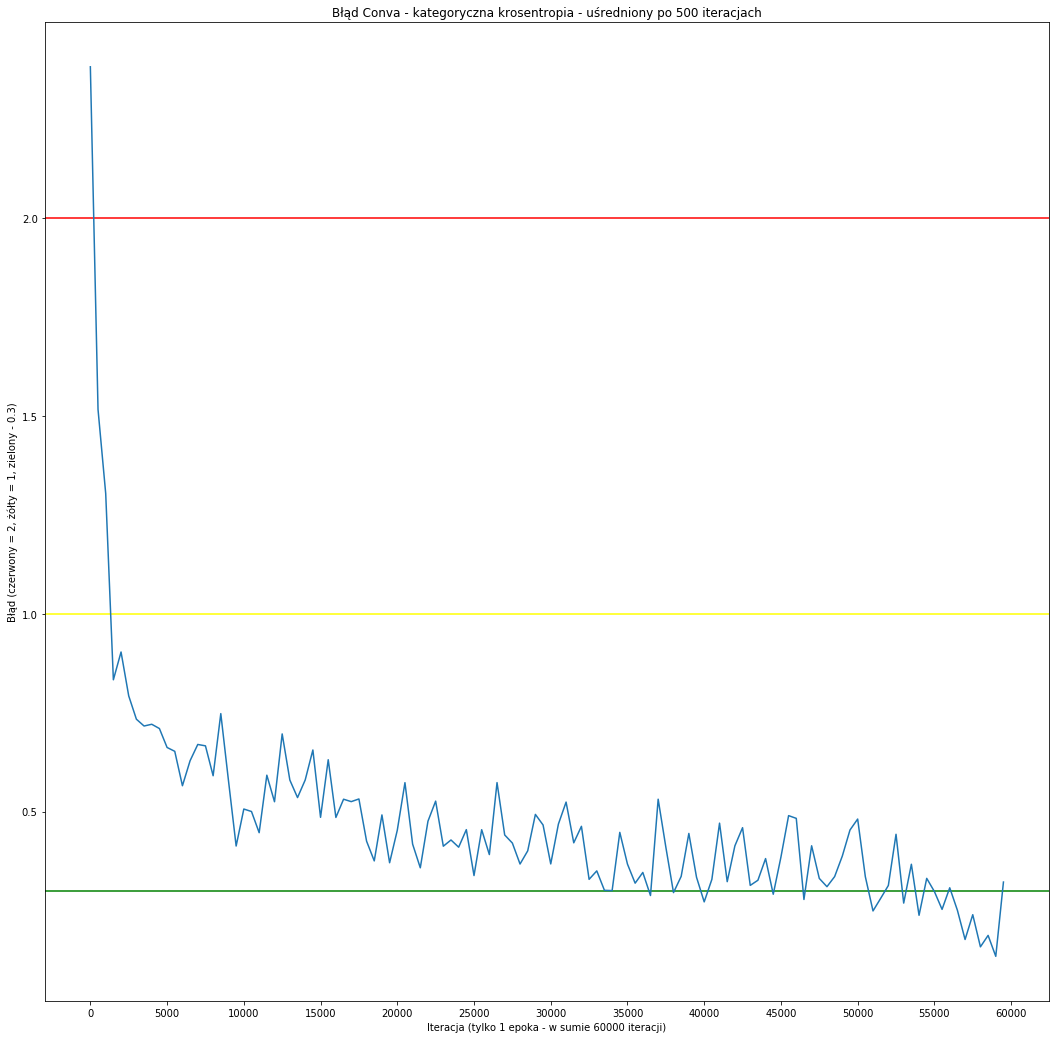

In [36]:
print(w2.shape)
fig, ax=plt.subplots(1, 1, figsize=(18,18))
dt=loopz
kgbo=500
dt2=dt//kgbo
ss=10

dkkk=[0]*dt2
for i in range(dt2):
    dkkk[i]=sum(sk[i*kgbo:(i+1)*kgbo])/kgbo

ax.set_title('Błąd Conva - kategoryczna krosentropia - uśredniony po {} iteracjach'.format(kgbo))
ax.set_xlabel('Iteracja (tylko 1 epoka - w sumie {} iteracji)'.format(loopz))
ax.set_xticklabels(range(0, loopz+1, kgbo*ss))
ax.set_xticks(range(0, loopz//kgbo+1, ss))
ax.set_ylabel('Błąd (czerwony = 2, żółty = 1, zielony - 0.3)'.format(loopz))
ax.axhline(2, color='red')
ax.axhline(1, color='yellow')
ax.axhline(0.3, color='green')
ax.plot(dkkk)
plt.show()

In [47]:
num=10000
won=0
dp2=np.zeros((10,10), dtype='int64')

for jj in range(num):
    img=testX[jj]
    img=img/255
    img=img.reshape(img.shape[0], img.shape[1], 1)
    """img1=img.copy()
    img=np.append(img, img1, axis=2)
    img=np.append(img, img1, axis=2)"""

    m2=[0]*10
    m3=[0]*10
    m4=[0]*10
    m8=[0]*10
    #Forw - Konwolucja, Relu, Pooling
    for i in range(10):
        m2[i]=conv_forw(img, matt[i])
        m3[i]=relu(m2[i])
        m4[i], Face1=pool_forw(m3[i], (2,2))
        m8[i]=m4[i].reshape(m4[i].shape[0]*m4[i].shape[1]*m4[i].shape[2])

    """m5=[0]*10
    m6=[0]*10
    m7=[0]*10
    #Forw - Konwolucja, Relu, Pooling
    for i in range(10):
        m5[i]=conv_forw(m4[i], matt2[i]) 
        m6[i]=relu(m5[i])
        m7[i], Face2=pool_forw(m6[i], (2,2))
        m8[i]=m7[i].reshape(m7[i].shape[0]*m7[i].shape[1]*m7[i].shape[2])"""


    #Forw - 2*FC na macierzach
    kk=np.asarray(m8)
    m9=np.asmatrix(kk.reshape(kk.shape[0]*kk.shape[1], 1))
    #print(len(m9))

    s1=w1*m9
    #s2=sigmoid_forw(s1)
    s2=rell_forw(s1)
    s3=w2*s2
    s4=sigmoid_forw(s3)

    #Koszt
    dp=np.asarray([0]*10).reshape(10, 1)
    dp[testy[jj],0]=1
    der, suma=cost(dp, s4)
    mxi=0
    for i in range(10):
        if (s4[i,0]>s4[mxi,0]):
            mxi=i
    if (mxi==testy[jj]):
        won+=1
    
    dp2[mxi,testy[jj]]+=1
    #print(mxi, testy[jj])
print('Skutecznosc na {} testach: {}'.format(num, won/num))

Skutecznosc na 10000 testach: 0.9519


[[ 970    0   14    1    3    7   15    5   13    7]
 [   0 1122   11    0    5    6    4   12    1    6]
 [   0    0  951    2    5    1    0   14    2    1]
 [   0    5   13  982    0   13    1    9    5   11]
 [   0    1    2    0  895    0    1    4    3    5]
 [   0    1    1    4    1  828    9    1    0    2]
 [   5    3   12    1   15   13  919    0    5    1]
 [   1    0    7    4    1    1    0  954    3    8]
 [   3    3   17    9    3   17    9    3  935    5]
 [   1    0    4    7   54    6    0   26    7  963]]


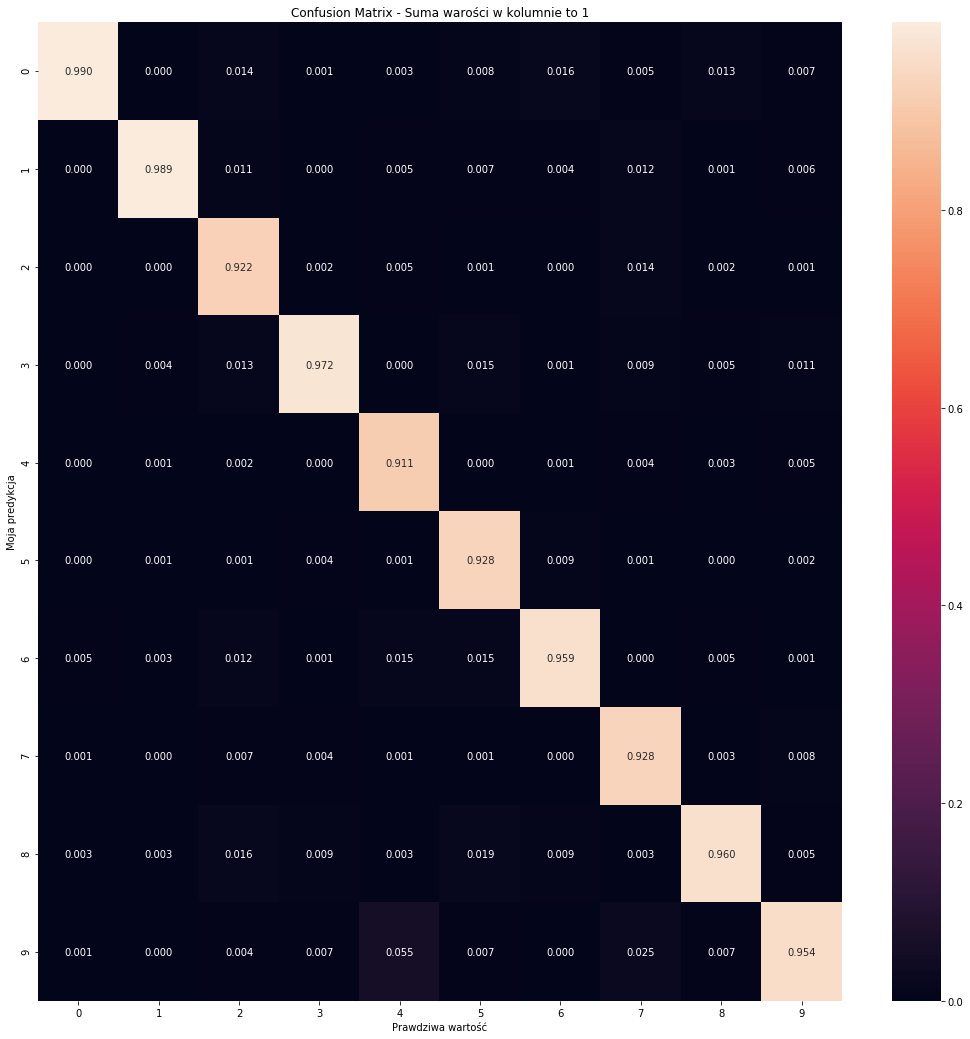

In [76]:
dk2=dp2*0
dk2=dk2.astype('float64')
liss=[0]*10
for i in range(dp2.shape[1]):
    liss[i]=sum(dp2[:,i])
    
for j in range(dk2.shape[1]):
    for i in range(dk2.shape[0]):
        dk2[i,j]=dp2[i,j]/liss[j]


print(dp2)


fig,ax=plt.subplots(1, 1, figsize=(18,18))
sns.heatmap(dk2, ax=ax, annot=True, fmt='.3f')
ax.set_xlabel('Prawdziwa wartość')
ax.set_ylabel('Moja predykcja')
ax.set_title('Confusion Matrix - Suma warości w kolumnie to 1')
plt.show()

In [32]:
##Od tego miejsca śmieci do debugu
###
###
###


k1=np.asarray([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
k1=k1.reshape(k1.shape[0], k1.shape[1], 1)
mathr=np.asarray([[1,2,3],[-1,-2,-3],[-10,10,20]])
c1=conv_forw(k1, mathr)
#c1=c1.reshape(c1.shape[0], c1.shape[1])
kgb=pool_forw(k1, (2,2))

print(kgb[1].reshape(kgb[1].shape[0], kgb[1].shape[1]))


[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 1. 0. 1.]]


In [139]:
dkk=[0]*10
for i in range(100):
    dkk[testy[i]]+=1
print(dkk)


#print(kk[3:kk.shape[0]-4,1:kk.shape[1]-2].shape)
#print(print(kk[3:kk.shape[0]-4,1:kk.shape[1]-2]))
#print(z)
#TT=(kk[3:kk.shape[0]-4,1:kk.shape[1]-2]==z)
#print(TT[TT==False])

[8, 14, 8, 11, 14, 7, 10, 15, 2, 11]


(1048, 698, 3) (7, 7)
2 2
(1050, 705, 3) (7, 7)
(150, 100)
150 100


In [17]:
mat=mymat
Y=np.ndarray((z.shape[0]*mat.shape[0], z.shape[1]*mat.shape[1]*3, z.shape[2]*2), dtype='float64')
t1=time.time()
for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
        for ij in range(z.shape[2]):
            Y[i:i+1,j,ij]=1
t2=time.time()
print(t2-t1)
print(Y.shape[0]*Y.shape[1]*Y.shape[2])

7.269612789154053
29625912


In [10]:
k=[random.random() for i in range(10)]
print(k)

[0.5984270187569013, 0.9671677742926911, 0.7976401137331915, 0.053760428992956966, 0.25749371422047285, 0.16253284123891132, 0.9060344103299387, 0.2756248627348449, 0.5445703657707015, 0.39006604163079217]


In [ ]:
z=cv2.imread("E:\W3\GGHard.jpg")
#z=z/255
mymat=np.asarray([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
z=conv_forw(z, mymat)
z=relu(z)
t1=time.time()
z, dt=pool_forw(z,(7,7))
t2=time.time()
print(t2-t1)
print(dt.shape)
#z=pool(z,(7,7))

"""fig, ax=plt.subplots(1,1,figsize=(20,20))
ax.imshow(z)
ax.axis('off')
plt.show()"""

In [ ]:
def conv_forw(X, mat):
    Z=np.ndarray((X.shape[0]-mat.shape[0]+1, X.shape[1]-mat.shape[1]+1, X.shape[2]), dtype='int64')
    Z=Z*0
    print(type(X))
    X=X.astype('int64')
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*X
            ff=ff[i:X.shape[0]-mat.shape[0]+i+1,j:X.shape[1]-mat.shape[1]+j+1]
            Z=Z+ff
    return Z

def conv_forw2(X, mat):
    Z=np.ndarray((X.shape[0]-mat.shape[0]+1, X.shape[1]-mat.shape[1]+1, X.shape[2]), dtype='int64')
    Z=Z*0
    print(type(X))
    X=X.astype('int64')    
    
    print(Z.shape[0]*Z.shape[1]*mat.shape[0]*mat.shape[0])
    xz1=mat.shape[0]
    xz2=mat.shape[1]
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            ii=0
            while (ii<xz1):
                jj=0
                while(jj<xz2):
                    Z[i,j]=1
                    jj+=1
                ii+=1
    return Z
            
B=np.asarray([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
kurl=r"E:\W3\GGHard.jpg"
kk=cv2.imread(kurl)

t1=time.time()
nightmare=conv_forw2(kk, B)
t2=time.time()
print(t2-t1)
t1=time.time()
nightmare2 = ndimage.convolve(kk.astype('int64'), B.reshape(3,3,1))
t2=time.time()
print(t2-t1)

fig, ax=plt.subplots(1,2,figsize=(22,22))
ax[0].imshow(nightmare2)
ax[0].axis('off')
ax[1].imshow(nightmare)
ax[1].axis('off')
plt.show()

In [ ]:
print(kk.shape)
print(nightmare2[1:nightmare2.shape[0]-1,1:nightmare2.shape[1]-1])
print(nightmare)

def relu(x):
    if (x<0):
        return 0
    return x

def pool_forward(X):
    Y=pd.Series([True]*X.shape[0])
    Y2=pd.Series([True]*X.shape[1])
    
    Y[Y.index%2==0]=False
    Y2[Y2.index%2==0]=False 
    KK1=X[Y][:,Y2]
    KK2=X[Y][:,~Y2]
    KK3=X[~Y][:,Y2]
    KK4=X[~Y][:,~Y2]
    
    Dt=KK1*0+1
    Exit=KK1
    Dt[Exit<KK2]=2
    Exit[Exit<KK2]=KK2[Exit<KK2]
    Dt[Exit<KK3]=3
    Exit[Exit<KK3]=KK3[Exit<KK3]
    Dt[Exit<KK4]=4
    Exit[Exit<KK4]=KK3[Exit<KK4]
    
    return (Dt, KK1)

t1=time.time()
Res, KK=pool_forward(nightmare)
t2=time.time()
print(t2-t1)

print(nightmare[:4,:4,0])

#Dodanie wersetu w 2 wymiarze
print(KK.shape)
s=[0]*KK.shape[0]*KK.shape[2]
s=np.asarray(s).reshape(KK.shape[0], 1, 3)
GG=np.append(KK, s, axis=1)
print(GG.shape)

In [98]:
n1, n2 = np.arange(5), np.arange(5)
Y=m7[0]
n1=np.arange(m7[0].shape[0])

f1=pd.Series([1]*Y.shape[0])
f2=pd.Series([1]*Y.shape[1])
f3=pd.Series([1]*Y.shape[2])

n1=np.asarray(f1[(f1.index%2)==0].index)
n2=np.asarray(f2[(f2.index%2)==1].index)
n3=np.asarray(f3.index)

m7[0][n1,n2]=13
print(m7[0][np.ix_(n1, n2,n3)].shape)
print(m7[0].shape)

(3, 3, 3)
(6, 6, 3)


In [119]:
print(math.exp(-100000))

0.0


In [71]:
print(matt)

[[[-1.80641111e-01  1.01303406e+00  5.68658521e-02]
  [-1.50180242e-01 -4.49518778e-01  2.29888229e-01]
  [-1.49464212e-01  1.79568202e-02  5.63098800e-01]]

 [[ 3.57100431e-01 -1.24985684e-01 -1.44566969e-01]
  [ 5.21873333e-01  9.49807180e-01  8.12153844e-01]
  [-1.77566089e-01 -6.69357460e-01  4.61081356e-01]]

 [[ 8.51013511e-01 -3.23042716e-01 -5.74604168e-01]
  [ 1.54445548e-01 -2.12365245e-01 -6.03171539e-01]
  [ 1.08646375e+00 -3.59921150e-01 -3.14678410e-01]]

 [[-3.09463601e-01 -8.49167675e-01  4.21892386e-01]
  [-9.78466819e-02  4.85793427e-01  4.07272130e-01]
  [-4.93156935e-01 -2.03789750e-01 -7.12313815e-02]]

 [[-8.53628217e-02 -7.04846645e-04  6.31339778e-03]
  [ 5.44888689e-01 -4.57835885e-01 -4.06130290e-01]
  [-7.09531689e-02 -4.13826322e-01  3.46471223e-01]]

 [[-3.29109786e-01  6.69617081e-01  4.80251536e-01]
  [-4.98654748e-01  5.22653924e-02 -4.02342825e-01]
  [ 3.54233047e-01 -4.11030534e-01 -4.91160409e-02]]

 [[-1.87180082e-01  8.45536081e-04  4.05606974e-02]


In [ ]:
##DIRT

#Tworzę większą tablicę zer i "wkładam" w nią X - array
def my_pad(X, a, b, c, d):    
    Y=np.zeros((X.shape[0]+b+d, X.shape[1]+a+c, X.shape[2]), dtype='float64')
    Y[b:X.shape[0]+b,a:X.shape[1]+a,:]=X
    return Y

def conv_forw(X, mat):
    Z=np.zeros((X.shape[0]-mat.shape[0]+1, X.shape[1]-mat.shape[1]+1, X.shape[2]), dtype='int64')
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*X
            ff=ff[i:X.shape[0]-mat.shape[0]+i+1,j:X.shape[1]-mat.shape[1]+j+1]
            Z=Z+ff
    return Z

def conv_back(X, mat, Der):
    Z=np.ndarray((X.shape[0], X.shape[1], X.shape[2]), dtype='float64')
    matd=mat*0
    Z=Z*0
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*Der
            Z[i:Der.shape[0]+i,j:Der.shape[1]+j]=Z[i:Der.shape[0]+i,j:Der.shape[1]+j]+ff
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*X
            ff=ff[i:X.shape[0]-mat.shape[0]+i+1,j:X.shape[1]-mat.shape[1]+j+1]
            matd[i,j]=sum(sum(sum(np.multiply(ff, Der))))
    return (Z, matd)

def relu(X):
    Y=X.copy()
    Y[Y<0]=0
    return Y

def relu_back(X, Der):
    Sd=Der.copy()
    Sd[X<0.0000001]=0
    return Sd

def pool_forw(X, mat):
    t1=(mat[0]-X.shape[0]%mat[0])%mat[0]
    t2=(mat[1]-X.shape[1]%mat[1])%mat[1]
    
    Y=my_pad(X, t2//2, t1//2, (t2//2+t2%2), t1//2+t1%2)
    silver_in_blood=np.asarray([[0]*(Y.shape[1]//mat[1])]*(Y.shape[0]//mat[0]))
    
    Exit=np.zeros(Y.shape, dtype='float64')
    Exit=Exit[:(Exit.shape[0]//mat[0]),:(Exit.shape[1]//mat[1])]
    
    Truth=np.zeros(Y.shape, dtype='int64')
    Truth2=np.zeros(Y.shape, dtype='int64')
    Pure=np.zeros(Y.shape, dtype='float64')
    
    Truth=Truth[:(Truth.shape[0]//mat[0]),:(Truth.shape[1]//mat[1])]
    Truth2=Truth2[:(Truth2.shape[0]//mat[0]),:(Truth2.shape[1]//mat[1])]
    
    for i in range(mat[0]):
        for j in range(mat[1]):
            Bleeding_One=Y[list(range(i, Y.shape[0], mat[0]))][:,list(range(j, Y.shape[1], mat[1]))]
            #Bleeding_One=Y[np.ix_(list(range(0, Y.shape[0], mat[0])),list(range(0, Y.shape[1], mat[1])))]
            
            Truth[Exit<Bleeding_One]=i
            Truth2[Exit<Bleeding_One]=j
            Exit[Exit<Bleeding_One]=Bleeding_One[Exit<Bleeding_One]
    
    for i in range(Truth.shape[0]):
        for j in range(Truth.shape[1]):
            for ij in range(Truth.shape[2]):
                Pure[i*mat[0]+Truth[i,j,ij],j*mat[1]+Truth2[i,j,ij],ij]=1
    return (Exit, Pure)

def pool_back(X, mat, dim):
    Y=np.ndarray((X.shape[0]*mat[0], X.shape[1]*mat[1], X.shape[2]), dtype='float64')
    
    for i in range(mat[0]):
        for j in range(mat[1]):
            Y[np.ix_(np.asarray(list(range(i,Y.shape[0],mat[0]))),np.asarray(list(range(j,Y.shape[1],mat[1]))))]=X
    Y=Y*dim
    return Y


def sigmoid(x):
    try:
        s=1/(1+math.exp(-x))
        return s
    except:
        return 0
    
def sigmoid_forw(v):
    return np.asmatrix(np.apply_along_axis(sigmoid, 1, v).reshape(v.shape[0], 1))

def sigmoid_back(v):
    return np.asmatrix(np.apply_along_axis(lambda x: sigmoid(x)*(1-sigmoid(x)), 1, v).reshape(v.shape[0], 1))

def rell_forw(v):
    return np.asmatrix(np.apply_along_axis(lambda x: max(0.0, x), 1, v).reshape(v.shape[0], 1))

def rell_back(v):
    return np.asmatrix(np.apply_along_axis(lambda x: np.sign(max(0.0, x)), 1, v).reshape(v.shape[0], 1))

def cost(act, pred):
    summ=0
    der=pred*0
    
    for i in range(pred.shape[0]):        
        if ((pred[i,0]==0 and act[i,0]==0) or (pred[i,0]==1 and act[i,0]==1)):
            der[i,0]=0
        else:
            if (pred[i,0]<0.000001):
                pred[i,0]=0.000001
            elif(pred[i,0]>0.99999):
                pred[i,0]=0.99999
            der[i,0]=-act[i,0]/pred[i,0]+(1-act[i,0])/(1-pred[i,0])
        
        if (pred[i,0]<0.000001):
            pred[i,0]=0.000001
        elif(pred[i,0]>0.99999):
            pred[i,0]=0.99999
        
        summ=summ-act[i,0]*math.log(pred[i,0])-(1-act[i,0])*math.log(1-pred[i,0])
        
    return (der, summ)

#ccn - learning rate, loopz - number of iterations, streetcleaner - hardcoded number of weights in first Fully connected layer
ccn=0.0002
loopz=1000
streetcleaner=1690

matt=[0]*10
matt2=[0]*10
for i in range(10):
    matt[i]=np.asarray([np.random.normal(0, 0.4) for j in range(9)]).reshape(3,3)
    matt2[i]=np.asarray([np.random.normal(0, 0.4) for j in range(9)]).reshape(3,3)

#img=cv2.imread("E:\W3\GGHard.jpg")
w1=np.asmatrix(np.asarray([np.random.normal(0, 0.4) for j in range(streetcleaner*20)]).reshape(20,streetcleaner))
#bw1=np.random.normal(0, 0.4)
w2=np.asmatrix(np.asarray([np.random.normal(0, 0.4) for j in range(10*20)]).reshape(10,20))
#bw2=np.random.normal(0, 0.4)

m2=[0]*10
m3=[0]*10
m4=[0]*10
m5=[0]*10
m6=[0]*10
m7=[0]*10
m8=[0]*10
mtb2=[0]*10
mtb3=[0]*10
mtb4=[0]*10
mtb5=[0]*10
mtb6=[0]*10
mtb7=[0]*10
mtb8=[0]*10


sk=[0]*loopz
t1=time.time()
for jj in range(loopz):
    img=trainX[jj]
    img=img/255
    img=img.reshape(img.shape[0], img.shape[1], 1)
    """img1=img.copy()
    img=np.append(img, img1, axis=2)
    img=np.append(img, img1, axis=2)"""
    
    #Forw - Konwolucja, Relu, Pooling
    
    for i in range(10):
        m2[i]=conv_forw(img, matt[i])
        m3[i]=relu(m2[i])
        m4[i], Face1=pool_forw(m3[i], (2,2))
        m8[i]=m4[i].reshape(m4[i].shape[0]*m4[i].shape[1]*m4[i].shape[2])
    
    """#Forw - Konwolucja, Relu, Pooling
    for i in range(10):
        m5[i]=conv_forw(m4[i], matt2[i]) 
        m6[i]=relu(m5[i])
        m7[i], Face2=pool_forw(m6[i], (2,2))
        m8[i]=m7[i].reshape(m7[i].shape[0]*m7[i].shape[1]*m7[i].shape[2])"""

    #Forw - 2*FC na macierzach
    kk=np.asarray(m8)
    m9=np.asmatrix(kk.reshape(kk.shape[0]*kk.shape[1], 1))
    #print(len(m9))

    s1=w1*m9#+bw1
    #s2=sigmoid_forw(s1)
    s2=rell_forw(s1)
    s3=w2*s2#+bw2
    #s4=sigmoid_forw(s3)
    s4=rell_forw(s3)
    
    #Koszt
    dp=np.asarray([0]*10).reshape(10, 1)
    dp[trainy[jj],0]=1
    der, suma=cost(dp, s4)
    sk[jj]=suma
    print(suma)
    
    #Back - 2.FC
    #dk2=np.asmatrix(np.asarray(sigmoid_back(s3))*np.asarray(der))
    dk2=np.asmatrix(np.asarray(rell_back(s3))*np.asarray(der))
    weight_delta2=dk2*s2.T
    #bw2_delta=sum(dk2)[0,0]
    dk1=w2.T*dk2

    #Back - 1.FC
    #dk1=np.asmatrix(np.asarray(sigmoid_back(s1))*np.asarray(dk1))
    dk1=np.asmatrix(np.asarray(rell_back(s1))*np.asarray(dk1))
    weight_delta1=dk1*m9.T
    #bw1_delta=sum(dk1)[0,0]
    dk0=w1.T*dk1
    

    #Back - 2*Konw, RElu, Pooling
    #dkl=np.asarray(dk0).reshape(10, m7[0].shape[0], m7[0].shape[1], m7[0].shape[2])
    dkl=np.asarray(dk0).reshape(10, m4[0].shape[0], m4[0].shape[1], m4[0].shape[2])
    
    """for i in range(10):
        mtb8[i]=pool_back(dkl[i], (2,2), Face2)
        cz=m6[i].shape
        nw=mtb8[i].shape
        mtb8[i]=mtb8[i][(nw[0]-cz[0])//2:cz[0]+(nw[0]-cz[0])//2, (nw[1]-cz[1])//2:cz[1]+(nw[1]-cz[1])//2]
        #print(m6[i].shape, mtb8[i].shape)
        mtb7[i]=relu_back(m6[i], mtb8[i])
        mtb6[i], Dr2=conv_back(m4[i], matt2[i], mtb7[i])"""
    
    for i in range(10):
        #mtb5[i]=pool_back(mtb6[i], (2,2), Face1)
        mtb5[i]=pool_back(dkl[i], (2,2), Face1)
        cz=m3[i].shape
        nw=mtb5[i].shape
        mtb5[i]=mtb5[i][(nw[0]-cz[0])//2:cz[0]+(nw[0]-cz[0])//2, (nw[1]-cz[1])//2:cz[1]+(nw[1]-cz[1])//2]
        mtb4[i]=relu_back(m3[i], mtb5[i])
        mtb3[i], Dr=conv_back(img, matt[i], mtb4[i])

    w1-=weight_delta1*ccn
    #bw1-=bw1_delta*ccn*0.1
    w2-=weight_delta2*ccn
    #bw2-=bw2_delta*ccn*0.05
    matt-=Dr*ccn
    #matt2-=Dr2*ccn
    

t2=time.time()
print(t2-t1)
print(s4)